<a href="https://colab.research.google.com/github/ChanZH0525/WOA-7015-AA/blob/main/CNN_Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQA-RAD Baseline: VGG16 + LSTM + Stacked Attention Network

**Architecture:**
- Image Encoder: VGG16 (pre-trained, frozen)
- Question Encoder: LSTM (300-dim embedding, 512 hidden)
- Attention: 2-layer Stacked Attention Network
- Classifier: dropout 0.3, direct mapping

---
## 📦 Section 0: Setup

### 0.1 Install Dependencies

In [ ]:
!pip install torch torchvision pillow pandas numpy matplotlib scikit-learn nltk -q

import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("✓ Dependencies installed")

✓ Dependencies installed


### 0.2 Import Libraries

In [ ]:
import os
import random
import zipfile
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.corpus import wordnet as wn

print("✓ Libraries imported")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

✓ Libraries imported
PyTorch: 2.9.0+cu126
CUDA: True


### 0.3 Set Random Seed

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"✓ Seed set to {seed}")

SEED = 42
set_seed(SEED)

✓ Seed set to 42


### 0.4 Configure Device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("="*80)
print("DEVICE CONFIGURATION")
print("="*80)
print(f"Device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.memory_allocated(0)/1e9:.2f} GB")
else:
    print("Using CPU (training will be slower)")
print("="*80)

DEVICE CONFIGURATION
Device: cuda
GPU: Tesla T4
Memory: 0.00 GB


### 0.5 Upload Data Files

In [ ]:
from google.colab import files

print("="*80)
print("FILE UPLOAD")
print("="*80)
print("Upload: VQA_RAD_Preprocessed.csv and VQA_RAD_Image_Folder.zip")

uploaded = files.upload()

print(f"\n✓ Uploaded {len(uploaded)} files")
print("="*80)

FILE UPLOAD
Upload: VQA_RAD_Preprocessed.csv and VQA_RAD_Image_Folder.zip


Saving VQA_RAD_Image_Folder.zip to VQA_RAD_Image_Folder.zip
Saving VQA_RAD_Preprocessed.csv to VQA_RAD_Preprocessed.csv

✓ Uploaded 2 files


### 0.6 Extract Images

In [ ]:
print("Extracting images...")

with zipfile.ZipFile('VQA_RAD_Image_Folder.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

IMAGE_DIR = 'VQA_RAD_Image_Folder'
CSV_FILE = 'VQA_RAD_Preprocessed.csv'

print(f"✓ Images extracted to {IMAGE_DIR}")
print(f"✓ CSV: {CSV_FILE}")

Extracting images...
✓ Images extracted to VQA_RAD_Image_Folder
✓ CSV: VQA_RAD_Preprocessed.csv


---
## ⚙️ Section 1: Configuration

In [ ]:
class Config:
    # Paths
    CSV_PATH = CSV_FILE
    IMAGE_DIR = IMAGE_DIR

    # Random seed
    SEED = 42
    DEVICE = device

    # Image
    IMAGE_SIZE = 224
    IMAGENET_MEAN = [0.485, 0.456, 0.406]
    IMAGENET_STD = [0.229, 0.224, 0.225]

    # Question
    MAX_QUESTION_LENGTH = 21
    EMBEDDING_DIM = 300
    LSTM_HIDDEN_SIZE = 512
    LSTM_NUM_LAYERS = 1

    # Attention
    ATTENTION_DIM = 512
    NUM_ATTENTION_LAYERS = 2

    # Training
    BATCH_SIZE = 16
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 1e-5  # L2 regularization
    NUM_EPOCHS = 100
    PATIENCE = 20
    TRAIN_VAL_SPLIT = 0.85

    # Will be set after building vocab/labels
    VOCAB_SIZE = None
    NUM_CLASSES = None

config = Config()

print("="*80)
print("CONFIGURATION")
print("="*80)
print(f"Device: {config.DEVICE}")
print(f"Batch size: {config.BATCH_SIZE}")
print(f"Learning rate: {config.LEARNING_RATE}")
print(f"L2 weight decay: {config.WEIGHT_DECAY}")
print(f"Max question length: {config.MAX_QUESTION_LENGTH}")
print(f"Embedding dim: {config.EMBEDDING_DIM}")
print(f"LSTM hidden: {config.LSTM_HIDDEN_SIZE}")
print(f"Attention layers: {config.NUM_ATTENTION_LAYERS}")
print("="*80)

CONFIGURATION
Device: cuda
Batch size: 16
Learning rate: 0.001
L2 weight decay: 1e-05
Max question length: 21
Embedding dim: 300
LSTM hidden: 512
Attention layers: 2


---
## 📊 Section 2: Data Loading & Preparation

1. Load data
2. Partition FIRST (train/val/test)
3. Build vocabulary from TRAINING only
4. Build labels from TRAINING only

This ensures zero information leakage from test/validation sets.

### 2.1 Load Data

In [ ]:
print("="*80)
print("LOADING DATA")
print("="*80)

df = pd.read_csv(config.CSV_PATH)

print(f"Total samples: {len(df)}")
print(f"Columns: {list(df.columns)}")
print(f"\nSplit distribution:")
print(df['split'].value_counts())
print(f"\nUnique answers: {df['answer'].nunique()}")

print("="*80)

LOADING DATA
Total samples: 2244
Columns: ['qid', 'phrase_type', 'qid_linked_id', 'image_case_url', 'image_name', 'image_organ', 'evaluation', 'question', 'question_rephrase', 'question_relation', 'question_frame', 'question_type', 'answer', 'answer_type', 'image_path', 'split']

Split distribution:
split
Train    1793
Test      451
Name: count, dtype: int64

Unique answers: 496


### 2.2 Data Partitioning

In [ ]:
print("="*80)
print("DATA PARTITIONING")
print("="*80)

# Separate test set (already split in dataset)
df_test = df[df['split'] == 'Test'].reset_index(drop=True)
df_train_full = df[df['split'] == 'Train'].reset_index(drop=True)

print(f"Original split:")
print(f"  Train (full): {len(df_train_full)}")
print(f"  Test: {len(df_test)}")

# Split train into train/val (stratified by answer_type, not individual answer)
train_idx, val_idx = train_test_split(
    range(len(df_train_full)),
    test_size=1-config.TRAIN_VAL_SPLIT,
    random_state=config.SEED,
    stratify=df_train_full['answer_type']  # CLOSED/OPEN
)

df_train = df_train_full.iloc[train_idx].reset_index(drop=True)
df_val = df_train_full.iloc[val_idx].reset_index(drop=True)

print(f"\nFinal split (stratified by answer_type):")
print(f"  Train: {len(df_train)} ({len(df_train)/len(df)*100:.1f}%)")
print(f"  Val: {len(df_val)} ({len(df_val)/len(df)*100:.1f}%)")
print(f"  Test: {len(df_test)} ({len(df_test)/len(df)*100:.1f}%)")

# Verify stratification
print(f"\nStratification check:")
for atype in ['CLOSED', 'OPEN']:
    train_pct = (df_train['answer_type'] == atype).mean() * 100
    val_pct = (df_val['answer_type'] == atype).mean() * 100
    print(f"  {atype}: Train {train_pct:.1f}%, Val {val_pct:.1f}%")

print("\n✓ Data partitioned")
print("="*80)

DATA PARTITIONING
Original split:
  Train (full): 1793
  Test: 451

Final split (stratified by answer_type):
  Train: 1524 (67.9%)
  Val: 269 (12.0%)
  Test: 451 (20.1%)

Stratification check:
  CLOSED: Train 57.2%, Val 57.2%
  OPEN: Train 42.8%, Val 42.8%

✓ Data partitioned


### 2.3 Build Vocabulary

In [ ]:
print("="*80)
print("BUILDING VOCABULARY")
print("="*80)

def build_vocabulary(questions, min_freq=1):
    word_counter = Counter()
    for question in questions:
        words = str(question).lower().split()
        word_counter.update(words)

    # Filter by frequency
    words = [w for w, c in word_counter.items() if c >= min_freq]
    words = sorted(words)

    # Create mappings (0=PAD, 1=UNK)
    word2idx = {'<PAD>': 0, '<UNK>': 1}
    for idx, word in enumerate(words, start=2):
        word2idx[word] = idx

    idx2word = {idx: word for word, idx in word2idx.items()}

    return word2idx, idx2word, word_counter

# Build from TRAINING only
word2idx, idx2word, word_counter = build_vocabulary(df_train['question'].tolist())

config.VOCAB_SIZE = len(word2idx)

print(f"Vocabulary size: {config.VOCAB_SIZE}")
print(f"  <PAD>: {word2idx['<PAD>']}")
print(f"  <UNK>: {word2idx['<UNK>']}")
print(f"  Unique words: {len(word2idx) - 2}")

print(f"\nTop 10 words:")
for word, count in word_counter.most_common(10):
    print(f"  {word}: {count}")

print(f"\n✓ Vocabulary built from training: {config.VOCAB_SIZE} words")
print("="*80)

BUILDING VOCABULARY
Vocabulary size: 984
  <PAD>: 0
  <UNK>: 1
  Unique words: 982

Top 10 words:
  the: 1144
  is: 1043
  this: 400
  what: 391
  in: 374
  image: 296
  there: 294
  of: 287
  are: 209
  a: 185

✓ Vocabulary built from training: 984 words


### 2.4 Build Answer Labels

In [ ]:
print("="*80)
print("BUILDING ANSWER LABELS")
print("="*80)

def build_answer_mapping(answers):
    unique_answers = sorted(set(answers))
    answer2idx = {ans: idx for idx, ans in enumerate(unique_answers)}
    idx2answer = {idx: ans for ans, idx in answer2idx.items()}
    return answer2idx, idx2answer

# Build from TRAINING only
answer2idx, idx2answer = build_answer_mapping(df_train['answer'].tolist())

config.NUM_CLASSES = len(answer2idx)

# Statistics from TRAINING only
answer_counts = df_train['answer'].value_counts()

print(f"Answer classes: {config.NUM_CLASSES}")
print(f"\nStatistics (training):")
print(f"  Most common: '{answer_counts.index[0]}' ({answer_counts.iloc[0]})")
print(f"  Least common: {(answer_counts == 1).sum()} with 1 sample")
print(f"  Mean: {answer_counts.mean():.2f}")

print(f"\nTop 10 answers:")
for i, (ans, count) in enumerate(answer_counts.head(10).items(), 1):
    print(f"  {i}. '{ans}': {count} (class {answer2idx[ans]})")

print(f"\n✓ Answer labels built from training: {config.NUM_CLASSES} classes")
print("="*80)

BUILDING ANSWER LABELS
Answer classes: 381

Statistics (training):
  Most common: 'no' (408)
  Least common: 205 with 1 sample
  Mean: 4.00

Top 10 answers:
  1. 'no': 408 (class 231)
  2. 'yes': 391 (class 380)
  3. 'axial': 26 (class 35)
  4. 'right': 14 (class 289)
  5. 'pa': 13 (class 247)
  6. 'left': 10 (class 172)
  7. 'ct': 9 (class 90)
  8. 'left kidney': 8 (class 178)
  9. 'brain': 8 (class 56)
  10. 'abscess': 7 (class 15)

✓ Answer labels built from training: 381 classes


---
## 🗂️ Section 3: Dataset & DataLoader

### 3.1 Image Transforms

In [ ]:
# Training transform (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0, hue=0),
    transforms.ToTensor(),
    transforms.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD)
])

# Val/Test transform (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=config.IMAGENET_MEAN, std=config.IMAGENET_STD)
])

print("✓ Transforms defined")
print("  Train: Rotation(10°) + ColorJitter(0.15,0.15,0,0)")
print("  Val/Test: No augmentation")

✓ Transforms defined
  Train: Rotation(10°) + ColorJitter(0.15,0.15,0,0)
  Val/Test: No augmentation


### 3.2 VQA Dataset Class

In [ ]:
class VQADataset(Dataset):
    def __init__(self, dataframe, image_dir, word2idx, answer2idx, transform, max_length):
        self.df = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.word2idx = word2idx
        self.answer2idx = answer2idx
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def encode_question(self, question):
        words = str(question).lower().split()
        indices = [self.word2idx.get(w, self.word2idx['<UNK>']) for w in words]
        actual_length = len(indices)

        # Pad or truncate
        if len(indices) < self.max_length:
            indices += [self.word2idx['<PAD>']] * (self.max_length - len(indices))
        else:
            indices = indices[:self.max_length]
            actual_length = self.max_length

        return torch.LongTensor(indices), actual_length

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Load image
        image_path = os.path.join(self.image_dir, row['image_name'])
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image)

        # Encode question
        question, question_length = self.encode_question(row['question'])

        # Handle unseen answers
        if row['answer'] in self.answer2idx:
            answer_label = self.answer2idx[row['answer']]
        else:
            answer_label = -1  # Unseen answer

        return {
            'image': image,
            'question': question,
            'question_length': question_length,
            'answer': answer_label,
            'answer_text': row['answer']
        }

print("✓ VQADataset class defined")
print("  Handles <UNK> words and unseen answers (-1)")

✓ VQADataset class defined
  Handles <UNK> words and unseen answers (-1)


### 3.3 Create DataLoaders

In [ ]:
train_dataset = VQADataset(df_train, config.IMAGE_DIR, word2idx, answer2idx,
                          train_transform, config.MAX_QUESTION_LENGTH)
val_dataset = VQADataset(df_val, config.IMAGE_DIR, word2idx, answer2idx,
                        val_test_transform, config.MAX_QUESTION_LENGTH)
test_dataset = VQADataset(df_test, config.IMAGE_DIR, word2idx, answer2idx,
                         val_test_transform, config.MAX_QUESTION_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

print("="*80)
print("DATALOADERS")
print("="*80)
print(f"Train: {len(train_dataset)} samples, {len(train_loader)} batches")
print(f"Val: {len(val_dataset)} samples, {len(val_loader)} batches")
print(f"Test: {len(test_dataset)} samples, {len(test_loader)} batches")
print("="*80)

DATALOADERS
Train: 1524 samples, 96 batches
Val: 269 samples, 17 batches
Test: 451 samples, 29 batches


---
## 🧠 Section 4: Model Architecture

### 4.1 Image Encoder (VGG16)

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pre-trained VGG16
        vgg16 = models.vgg16(pretrained=True)

        # Extract features up to conv5_3
        self.features = nn.Sequential(*list(vgg16.features.children())[:-1])

        # Freeze parameters
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, images):
        # images: (B, 3, 224, 224)
        features = self.features(images)  # (B, 512, 14, 14)

        # Reshape for attention: (B, 196, 512)
        B, C, H, W = features.shape
        features = features.view(B, C, H*W).transpose(1, 2)

        return features

print("✓ ImageEncoder defined")
print("  VGG16 (pre-trained, frozen)")
print("  Output: (batch, 196, 512)")

✓ ImageEncoder defined
  VGG16 (pre-trained, frozen)
  Output: (batch, 196, 512)


### 4.2 Question Encoder (LSTM)

In [ ]:
class QuestionEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers,
                           batch_first=True, bidirectional=False)
        self.hidden_size = hidden_size

    def forward(self, questions, lengths):
        # questions: (B, max_len)
        # lengths: (B,)

        embedded = self.embedding(questions)  # (B, max_len, embedding_dim)

        # Pack padded sequence
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        # LSTM
        _, (hidden, _) = self.lstm(packed)  # hidden: (num_layers, B, hidden_size)

        # Take last layer
        question_features = hidden[-1]  # (B, hidden_size)

        return question_features

print("✓ QuestionEncoder defined")
print("  Embedding + LSTM")
print("  Output: (batch, 512)")

✓ QuestionEncoder defined
  Embedding + LSTM
  Output: (batch, 512)


### 4.3 Stacked Attention Network

In [ ]:
class AttentionLayer(nn.Module):
    """
    Single attention layer.
    Computes attention weights over image regions given question.
    """
    def __init__(self, image_dim, question_dim, attention_dim):
        super(AttentionLayer, self).__init__()

        # Project image features
        self.image_proj = nn.Linear(image_dim, attention_dim)

        # Project question features
        self.question_proj = nn.Linear(question_dim, attention_dim)

        # Attention scoring
        self.attention_score = nn.Linear(attention_dim, 1)

    def forward(self, image_features, question_vector):
        """
        Args:
            image_features: (batch, 196, 512)
            question_vector: (batch, hidden_size)
        Returns:
            attended_features: (batch, 512)
            attention_weights: (batch, 196)
        """
        # Project image: (batch, 196, attention_dim)
        img_proj = self.image_proj(image_features)

        # Project question: (batch, attention_dim)
        ques_proj = self.question_proj(question_vector)

        # Broadcast question to all regions: (batch, 196, attention_dim)
        ques_proj = ques_proj.unsqueeze(1).expand_as(img_proj)

        # Combined features: (batch, 196, attention_dim)
        combined = torch.tanh(img_proj + ques_proj)

        # Attention scores: (batch, 196, 1)
        scores = self.attention_score(combined)

        # Attention weights: (batch, 196)
        attention_weights = F.softmax(scores.squeeze(2), dim=1)

        # Weighted sum: (batch, 512)
        attended_features = torch.bmm(
            attention_weights.unsqueeze(1),  # (batch, 1, 196)
            image_features  # (batch, 196, 512)
        ).squeeze(1)  # (batch, 512)

        return attended_features, attention_weights


class StackedAttention(nn.Module):
    """
    Stacked Attention Network with progressive refinement.
    """
    def __init__(self, image_dim, question_dim, attention_dim, num_layers=2):
        super(StackedAttention, self).__init__()

        self.num_layers = num_layers

        # First attention layer
        self.attention_layers = nn.ModuleList([
            AttentionLayer(image_dim, question_dim, attention_dim)
        ])

        # Additional layers (input is question + attended features)
        for _ in range(num_layers - 1):
            self.attention_layers.append(
                AttentionLayer(image_dim, question_dim + image_dim, attention_dim)
            )

    def forward(self, image_features, question_vector):
        """
        Args:
            image_features: (batch, 196, 512)
            question_vector: (batch, hidden_size)
        Returns:
            final_features: (batch, 512)
            all_attention_weights: List of (batch, 196) for each layer
        """
        all_attention_weights = []

        # First attention layer
        attended, weights = self.attention_layers[0](image_features, question_vector)
        all_attention_weights.append(weights)

        # Subsequent layers: progressive refinement
        for layer in self.attention_layers[1:]:
            # Combine question with previous attended features
            combined_question = torch.cat([question_vector, attended], dim=1)

            # Apply attention with enriched question
            attended, weights = layer(image_features, combined_question)
            all_attention_weights.append(weights)

        return attended, all_attention_weights

print("✓ Stacked Attention Network defined")
print("  AttentionLayer: Single attention computation")
print("  StackedAttention: Progressive refinement across layers")

✓ Stacked Attention Network defined
  AttentionLayer: Single attention computation
  StackedAttention: Progressive refinement across layers


### 4.4 Complete VQA Model

In [ ]:
class VQAModel(nn.Module):
    """
    Complete VQA model: VGG16 + LSTM + SAN + Classifier
    """
    def __init__(self, config, vocab_size, num_classes):
        super(VQAModel, self).__init__()

        # Image encoder (VGG16)
        self.image_encoder = ImageEncoder()

        # Question encoder (LSTM)
        self.question_encoder = QuestionEncoder(
            vocab_size,
            config.EMBEDDING_DIM,
            config.LSTM_HIDDEN_SIZE,
            config.LSTM_NUM_LAYERS
        )

        # Stacked attention
        self.attention = StackedAttention(
            image_dim=512,  # VGG16 conv5_3 channels
            question_dim=config.LSTM_HIDDEN_SIZE,
            attention_dim=config.ATTENTION_DIM,
            num_layers=config.NUM_ATTENTION_LAYERS
        )

        # Simplified classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512 + config.LSTM_HIDDEN_SIZE, num_classes)
        )

    def forward(self, images, questions, question_lengths):
        """
        Args:
            images: (batch, 3, 224, 224)
            questions: (batch, max_length)
            question_lengths: (batch)
        Returns:
            logits: (batch, num_classes)
            attention_weights: List of (batch, 196) for each layer
        """
        # Encode image: (batch, 196, 512)
        image_features = self.image_encoder(images)

        # Encode question: (batch, hidden_size)
        question_vector = self.question_encoder(questions, question_lengths)

        # Apply attention: (batch, 512), List[(batch, 196)]
        attended_features, attention_weights = self.attention(image_features, question_vector)

        # Combine
        combined = torch.cat([attended_features, question_vector], dim=1)

        # Classify
        logits = self.classifier(combined)

        return logits, attention_weights

print("✓ Complete VQA Model defined")
print("  Progressive attention refinement")
print("  Simplified classifier (dropout 0.3)")

✓ Complete VQA Model defined
  Progressive attention refinement
  Simplified classifier (dropout 0.3)


### 4.5 Initialize Model

In [ ]:
print("="*80)
print("MODEL INITIALIZATION")
print("="*80)

model = VQAModel(config, config.VOCAB_SIZE, config.NUM_CLASSES)
model = model.to(config.DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"\nModel architecture:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Frozen parameters (VGG16): {frozen_params:,}")

print(f"\nModel components:")
print(f"  Image encoder: VGG16 conv5_3 (frozen)")
print(f"  Question encoder: Embedding({config.VOCAB_SIZE}, {config.EMBEDDING_DIM}) + LSTM({config.LSTM_HIDDEN_SIZE})")
print(f"  Attention: {config.NUM_ATTENTION_LAYERS}-layer SAN with progressive refinement")
print(f"  Classifier: Simplified (dropout 0.3, direct 1024→{config.NUM_CLASSES})")

# Test forward pass
with torch.no_grad():
    sample_batch = next(iter(train_loader))
    sample_images = sample_batch['image'].to(config.DEVICE)
    sample_questions = sample_batch['question'].to(config.DEVICE)
    sample_lengths = torch.LongTensor(sample_batch['question_length'])

    logits, attn_weights = model(sample_images, sample_questions, sample_lengths)

    print(f"\nTest forward pass:")
    print(f"  Input images: {sample_images.shape}")
    print(f"  Input questions: {sample_questions.shape}")
    print(f"  Output logits: {logits.shape}")
    print(f"  Attention layers: {len(attn_weights)}")
    print(f"  Attention weights shape: {attn_weights[0].shape}")

print("\n✓ Model initialized successfully")
print("="*80)

MODEL INITIALIZATION
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 143MB/s]



Model architecture:
  Total parameters: 18,381,279
  Trainable parameters: 3,666,591
  Frozen parameters (VGG16): 14,714,688

Model components:
  Image encoder: VGG16 conv5_3 (frozen)
  Question encoder: Embedding(984, 300) + LSTM(512)
  Attention: 2-layer SAN with progressive refinement
  Classifier: Simplified (dropout 0.3, direct 1024→381)

Test forward pass:
  Input images: torch.Size([16, 3, 224, 224])
  Input questions: torch.Size([16, 21])
  Output logits: torch.Size([16, 381])
  Attention layers: 2
  Attention weights shape: torch.Size([16, 196])

✓ Model initialized successfully


In [ ]:
print("="*80)
print("PARAMETER BREAKDOWN")
print("="*80)

# Embedding layer (inside question_encoder)
embedding_params = sum(p.numel() for p in model.question_encoder.embedding.parameters())
print(f"Embedding layer: {embedding_params:,}")

# LSTM (inside question_encoder)
lstm_params = sum(p.numel() for p in model.question_encoder.lstm.parameters())
print(f"LSTM encoder: {lstm_params:,}")

# Attention mechanism
attention_params = sum(p.numel() for p in model.attention.parameters())
print(f"Attention mechanism: {attention_params:,}")

# Classifier
classifier_params = sum(p.numel() for p in model.classifier.parameters())
print(f"Classifier: {classifier_params:,}")

print("-"*80)
total_component = embedding_params + lstm_params + attention_params + classifier_params
print(f"Sum of components: {total_component:,}")

# Total trainable
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable (from model): {trainable:,}")

print("-"*80)
if total_component == trainable:
    print(f"✓ Parameter counts match!")
else:
    print(f"✗ Difference: {trainable - total_component:,}")

PARAMETER BREAKDOWN
Embedding layer: 295,200
LSTM encoder: 1,667,072
Attention mechanism: 1,313,794
Classifier: 390,525
--------------------------------------------------------------------------------
Sum of components: 3,666,591
Total trainable (from model): 3,666,591
--------------------------------------------------------------------------------
✓ Parameter counts match!


---
## 🎯 Section 5: Training

### 5.1 Compute Class Weights

TRAINING SET ANSWER FREQUENCY ANALYSIS

Total unique answers in training set: 381
Total training samples: 1524

Frequency statistics:
  Minimum frequency: 1
  Maximum frequency: 408
  Mean frequency: 4.00
  Median frequency: 1.0

 Distribution:
  Answers with frequency = 1: 205 (53.8%)
  Answers with frequency 2-5: 160 (42.0%)
  Answers with frequency 6-10: 11 (2.9%)
  Answers with frequency 11+: 5 (1.3%)

Top 10 most frequent answers:
  1. 'no': 408 occurrences (26.8%)
  2. 'yes': 391 occurrences (25.7%)
  3. 'axial': 26 occurrences (1.7%)
  4. 'right': 14 occurrences (0.9%)
  5. 'pa': 13 occurrences (0.9%)
  6. 'left': 10 occurrences (0.7%)
  7. 'ct': 9 occurrences (0.6%)
  8. 'left kidney': 8 occurrences (0.5%)
  9. 'brain': 8 occurrences (0.5%)
  10. 'abscess': 7 occurrences (0.5%)

Bottom 10 least frequent answers:
  1. 'in the thorasic aorta': 1 occurrence(s)
  2. 'periappendiceal fluid and fat stranding': 1 occurrence(s)
  3. 'double arch': 1 occurrence(s)
  4. 'isointense': 1 o

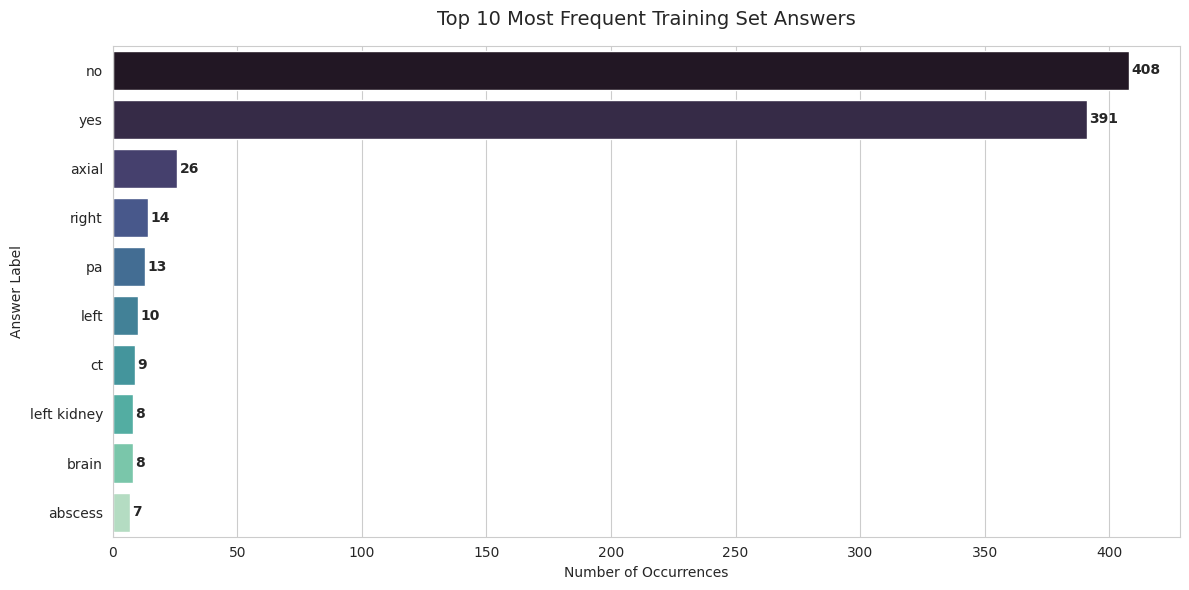

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("="*80)
print("TRAINING SET ANSWER FREQUENCY ANALYSIS")
print("="*80)

# Get training set answers
train_answers = df_train['answer'].value_counts()

print(f"\nTotal unique answers in training set: {len(train_answers)}")
print(f"Total training samples: {len(df_train)}")

print(f"\nFrequency statistics:")
print(f"  Minimum frequency: {train_answers.min()}")
print(f"  Maximum frequency: {train_answers.max()}")
print(f"  Mean frequency: {train_answers.mean():.2f}")
print(f"  Median frequency: {train_answers.median():.1f}")

print(f"\n Distribution:")
freq_1 = (train_answers == 1).sum()
freq_2_5 = ((train_answers >= 2) & (train_answers <= 5)).sum()
freq_6_10 = ((train_answers >= 6) & (train_answers <= 10)).sum()
freq_11_plus = (train_answers >= 11).sum()

print(f"  Answers with frequency = 1: {freq_1} ({freq_1/len(train_answers)*100:.1f}%)")
print(f"  Answers with frequency 2-5: {freq_2_5} ({freq_2_5/len(train_answers)*100:.1f}%)")
print(f"  Answers with frequency 6-10: {freq_6_10} ({freq_6_10/len(train_answers)*100:.1f}%)")
print(f"  Answers with frequency 11+: {freq_11_plus} ({freq_11_plus/len(train_answers)*100:.1f}%)")

print(f"\nTop 10 most frequent answers:")
for i, (answer, count) in enumerate(train_answers.head(10).items(), 1):
    print(f"  {i}. '{answer}': {count} occurrences ({count/len(df_train)*100:.1f}%)")

print(f"\nBottom 10 least frequent answers:")
for i, (answer, count) in enumerate(train_answers.tail(10).items(), 1):
    print(f"  {i}. '{answer}': {count} occurrence(s)")

# ==============================================================================
# VISUALIZATION OF TOP 10
# ==============================================================================

# 1. Select the top 10 data points directly from the train_answers variable
top_10_data = train_answers.head(10)

# 2. Initialize the plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# 3. Create the horizontal bar chart
# Use horizontal (y='index') so that long medical words are easy to read
ax = sns.barplot(
    x=top_10_data.values,
    y=top_10_data.index,
    hue=top_10_data.index,
    palette="mako",
    legend=False
)

# 4. Add the exact count labels to the end of each bar for clarity
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(
        width + 1,
        p.get_y() + p.get_height()/2,
        f'{int(width)}',
        va='center',
        fontweight='bold'
    )

# 5. Set labels based on the analysis headers
plt.title('Top 10 Most Frequent Training Set Answers', fontsize=14, pad=15)
plt.xlabel('Number of Occurrences')
plt.ylabel('Answer Label')

plt.tight_layout()
plt.show()

In [ ]:
print("="*80)
print("COMPUTING CLASS WEIGHTS")
print("="*80)

# Get training labels
train_labels = [answer2idx[ans] for ans in df_train['answer']]

# Compute balanced class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.FloatTensor(class_weights).to(config.DEVICE)

print(f"Classes: {len(class_weights)}")
print(f"Weight range: [{class_weights.min():.3f}, {class_weights.max():.3f}]")
print(f"Mean weight: {class_weights.mean():.3f}")

print("\n✓ Class weights computed from training data")
print("="*80)

COMPUTING CLASS WEIGHTS
Classes: 381
Weight range: [0.010, 4.000]
Mean weight: 2.919

✓ Class weights computed from training data


### 5.2 Loss and Optimizer

In [ ]:
# Loss function (weighted + ignore unseen answers)
criterion = nn.CrossEntropyLoss(weight=class_weights, ignore_index=-1)

# Optimizer with L2 regularization
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY  # L2 regularization
)

print("="*80)
print("LOSS & OPTIMIZER")
print("="*80)
print(f"Loss: Weighted CrossEntropyLoss")
print(f"  Class weights: balanced")
print(f"  Ignore index: -1 (unseen answers)")
print(f"\nOptimizer: Adam")
print(f"  Learning rate: {config.LEARNING_RATE}")
print(f"  Weight decay: {config.WEIGHT_DECAY} (L2 regularization)")
print("="*80)

LOSS & OPTIMIZER
Loss: Weighted CrossEntropyLoss
  Class weights: balanced
  Ignore index: -1 (unseen answers)

Optimizer: Adam
  Learning rate: 0.001
  Weight decay: 1e-05 (L2 regularization)


### 5.3 Training Functions

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in loader:
        images = batch['image'].to(device)
        questions = batch['question'].to(device)
        question_lengths = torch.LongTensor(batch['question_length'])
        answers = batch['answer'].to(device)

        # Forward
        logits, _ = model(images, questions, question_lengths)
        loss = criterion(logits, answers)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stats (only for valid answers, not -1)
        valid_mask = answers != -1
        if valid_mask.sum() > 0:
            predictions = logits.argmax(dim=1)
            correct += (predictions[valid_mask] == answers[valid_mask]).sum().item()
            total += valid_mask.sum().item()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / total if total > 0 else 0

    return avg_loss, accuracy

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(device)
            questions = batch['question'].to(device)
            question_lengths = torch.LongTensor(batch['question_length'])
            answers = batch['answer'].to(device)

            # Forward
            logits, _ = model(images, questions, question_lengths)
            loss = criterion(logits, answers)

            # Stats (only for valid answers)
            valid_mask = answers != -1
            if valid_mask.sum() > 0:
                predictions = logits.argmax(dim=1)
                correct += (predictions[valid_mask] == answers[valid_mask]).sum().item()
                total += valid_mask.sum().item()

            total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / total if total > 0 else 0

    return avg_loss, accuracy

print("✓ Training functions defined")
print("  train_one_epoch(), validate()")

✓ Training functions defined
  train_one_epoch(), validate()


### 5.4 Training Loop with Early Stopping

In [ ]:
print("="*80)
print("TRAINING")
print("="*80)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0
patience_counter = 0
best_model_state = None

for epoch in range(config.NUM_EPOCHS):
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, config.DEVICE
    )

    # Validate
    val_loss, val_acc = validate(
        model, val_loader, criterion, config.DEVICE
    )

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print progress
    print(f"Epoch {epoch+1}/{config.NUM_EPOCHS}")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = model.state_dict().copy()
        print(f"  ✓ New best validation accuracy: {best_val_acc:.4f}")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{config.PATIENCE})")

    if patience_counter >= config.PATIENCE:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print(f"\n✓ Training complete")
print(f"  Best validation accuracy: {best_val_acc:.4f}")
print("="*80)

TRAINING
Epoch 1/100
  Train - Loss: 6.0005, Acc: 0.0413
  Val   - Loss: 5.6719, Acc: 0.0427
  ✓ New best validation accuracy: 0.0427
Epoch 2/100
  Train - Loss: 4.9475, Acc: 0.1175
  Val   - Loss: 4.8577, Acc: 0.1068
  ✓ New best validation accuracy: 0.1068
Epoch 3/100
  Train - Loss: 2.8061, Acc: 0.2487
  Val   - Loss: 3.7476, Acc: 0.1624
  ✓ New best validation accuracy: 0.1624
Epoch 4/100
  Train - Loss: 1.0993, Acc: 0.3996
  Val   - Loss: 3.3420, Acc: 0.2479
  ✓ New best validation accuracy: 0.2479
Epoch 5/100
  Train - Loss: 0.4783, Acc: 0.5269
  Val   - Loss: 3.0973, Acc: 0.3462
  ✓ New best validation accuracy: 0.3462
Epoch 6/100
  Train - Loss: 0.2035, Acc: 0.6371
  Val   - Loss: 3.0267, Acc: 0.3932
  ✓ New best validation accuracy: 0.3932
Epoch 7/100
  Train - Loss: 0.1550, Acc: 0.6909
  Val   - Loss: 3.1530, Acc: 0.5043
  ✓ New best validation accuracy: 0.5043
Epoch 8/100
  Train - Loss: 0.1103, Acc: 0.7283
  Val   - Loss: 2.9235, Acc: 0.5128
  ✓ New best validation accuracy

### 5.5 Plot Training History

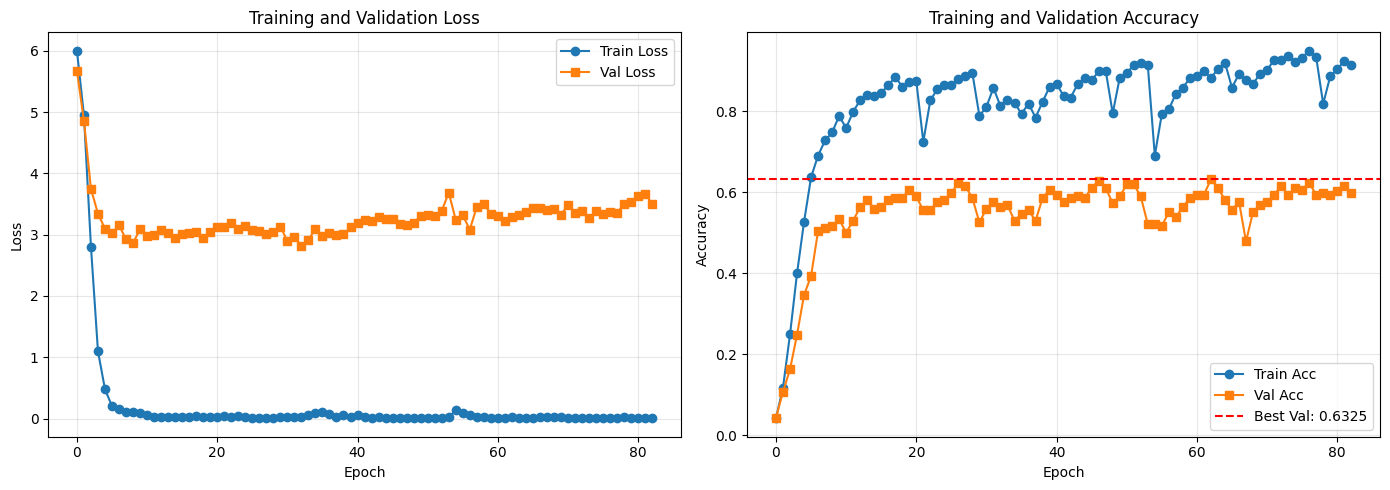

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.axhline(y=best_val_acc, color='r', linestyle='--', label=f'Best Val: {best_val_acc:.4f}')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 5.6 Load Best Model

In [ ]:
# Load best model weights
model.load_state_dict(best_model_state)
print(f"✓ Loaded best model (val acc: {best_val_acc:.4f})")

✓ Loaded best model (val acc: 0.6325)


---
## 📊 Section 6: Comprehensive Evaluation

Dual Reporting Strategy:
- Primary: Full test set (all 451 samples) - real-world performance
- Reference: Answerable subset (~333 samples) - model capability analysis

Samples with unseen answers are counted as incorrect in full test set metrics.

### 6.1 Get Test Predictions

In [ ]:
print("="*80)
print("TEST SET PREDICTIONS")
print("="*80)

all_predictions = []
all_true_labels = []
all_predicted_answers = []
all_true_answers = []
all_probabilities = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(config.DEVICE)
        questions = batch['question'].to(config.DEVICE)
        question_lengths = torch.LongTensor(batch['question_length'])
        answers = batch['answer'].to(config.DEVICE)

        # Forward pass
        logits, _ = model(images, questions, question_lengths)
        predictions = logits.argmax(dim=1)
        probabilities = F.softmax(logits, dim=1)

        # Store
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(answers.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

        # Convert to answer text
        for pred, true_text in zip(predictions.cpu().numpy(), batch['answer_text']):
            all_predicted_answers.append(idx2answer[pred])
            all_true_answers.append(true_text)

# Convert to arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)
all_probabilities = np.array(all_probabilities)

# Identify unseen answers
unseen_mask = all_true_labels == -1
answerable_mask = ~unseen_mask

num_unseen = unseen_mask.sum()
num_answerable = answerable_mask.sum()

print(f"\n✓ Collected predictions for {len(all_predictions)} test samples")
print(f"   Answerable (seen answers): {num_answerable} ({num_answerable/len(all_predictions)*100:.1f}%)")
print(f"   Unanswerable (unseen answers): {num_unseen} ({num_unseen/len(all_predictions)*100:.1f}%)")

# For full test set evaluation: convert unseen to impossible class
all_true_labels_eval = all_true_labels.copy()
all_true_labels_eval[unseen_mask] = -9999  # Will never match predictions

print("="*80)

TEST SET PREDICTIONS

✓ Collected predictions for 451 test samples
   Answerable (seen answers): 333 (73.8%)
   Unanswerable (unseen answers): 118 (26.2%)


### 6.2 Overall Accuracy

In [ ]:
print("="*80)
print("OVERALL TEST ACCURACY")
print("="*80)

# Full test set accuracy
overall_acc_full = accuracy_score(all_true_labels_eval, all_predictions)
correct_full = (all_predictions == all_true_labels_eval).sum()

# Answerable subset accuracy
overall_acc_answerable = accuracy_score(
    all_true_labels_eval[answerable_mask],
    all_predictions[answerable_mask]
)
correct_answerable = (all_predictions[answerable_mask] == all_true_labels_eval[answerable_mask]).sum()

print("\n[FULL TEST SET - Primary Metric]")
print(f"  Total samples: {len(all_predictions)}")
print(f"  Accuracy: {overall_acc_full:.4f} ({overall_acc_full*100:.2f}%)")
print(f"  Correct: {correct_full} / {len(all_predictions)}")

print("\n[ANSWERABLE SUBSET - Reference]")
print(f"  Total samples: {num_answerable}")
print(f"  Accuracy: {overall_acc_answerable:.4f} ({overall_acc_answerable*100:.2f}%)")
print(f"  Correct: {correct_answerable} / {num_answerable}")

print(f"\nNote: Full test includes {num_unseen} unanswerable samples (counted as incorrect)")
print("="*80)

OVERALL TEST ACCURACY

[FULL TEST SET - Primary Metric]
  Total samples: 451
  Accuracy: 0.3792 (37.92%)
  Correct: 171 / 451

[ANSWERABLE SUBSET - Reference]
  Total samples: 333
  Accuracy: 0.5135 (51.35%)
  Correct: 171 / 333

Note: Full test includes 118 unanswerable samples (counted as incorrect)


### 6.3 Prediction Distribution Analysis

In [ ]:
print("="*80)
print("PREDICTION DISTRIBUTION ANALYSIS")
print("="*80)

pred_counts = pd.Series(all_predicted_answers).value_counts()
true_counts = pd.Series(all_true_answers).value_counts()

print(f"\nTop 10 Predicted Answers:")
for i, (ans, count) in enumerate(pred_counts.head(10).items(), 1):
    pct = count / len(all_predicted_answers) * 100
    print(f"  {i}. '{ans}': {count} ({pct:.1f}%)")

print(f"\nTop 10 True Answers:")
for i, (ans, count) in enumerate(true_counts.head(10).items(), 1):
    pct = count / len(all_true_answers) * 100
    print(f"  {i}. '{ans}': {count} ({pct:.1f}%)")

print(f"\nClass collapse analysis:")
print(f"  Unique predictions: {len(pred_counts)}")
print(f"  Unique true answers: {len(true_counts)}")
print(f"  Coverage: {len(pred_counts) / len(true_counts) * 100:.1f}%")

print("="*80)

PREDICTION DISTRIBUTION ANALYSIS

Top 10 Predicted Answers:
  1. 'no': 128 (28.4%)
  2. 'yes': 122 (27.1%)
  3. 'axial': 10 (2.2%)
  4. 'retrocardiac': 7 (1.6%)
  5. 'oculomotor nerve cn iii and trigeminal nerves cn v': 6 (1.3%)
  6. 'left': 5 (1.1%)
  7. 'gi': 5 (1.1%)
  8. 'thickening of bronchi': 4 (0.9%)
  9. 'metastasis': 4 (0.9%)
  10. 'ct': 4 (0.9%)

Top 10 True Answers:
  1. 'no': 133 (29.5%)
  2. 'yes': 118 (26.2%)
  3. 'axial': 12 (2.7%)
  4. 'left': 6 (1.3%)
  5. 'right': 6 (1.3%)
  6. 'brain': 5 (1.1%)
  7. 'right upper lobe': 4 (0.9%)
  8. 'mri': 4 (0.9%)
  9. 'female': 4 (0.9%)
  10. 'right side': 3 (0.7%)

Class collapse analysis:
  Unique predictions: 115
  Unique true answers: 120
  Coverage: 95.8%


### 6.4 Unseen Answers Analysis

In [ ]:
print("="*80)
print("UNSEEN ANSWERS ANALYSIS")
print("="*80)
print("\nMethodology Validation:")
print("  ✅ We built vocabulary/labels from TRAINING only")
print("  ✅ This prevents information leakage")
print("  ✅ Some test samples have answers not seen during training")
print("  ✅ These samples are counted as incorrect (standard practice)\n")

train_answers = set(df_train['answer'].unique())
test_answers = set(df_test['answer'].unique())

unseen_answers = test_answers - train_answers
test_with_unseen = df_test[df_test['answer'].isin(unseen_answers)]

print(f"Training answers: {len(train_answers)}")
print(f"Test answers: {len(test_answers)}")
print(f"Unseen in test: {len(unseen_answers)}")

print(f"\nTest samples with unseen answers: {len(test_with_unseen)} / {len(df_test)} ({len(test_with_unseen)/len(df_test)*100:.1f}%)")

print(f"\nExamples of unseen answers:")
for i, ans in enumerate(sorted(list(unseen_answers))[:5], 1):
    count = (df_test['answer'] == ans).sum()
    print(f"  {i}. '{ans}' ({count} samples)")

print(f"\n✅ Impact: These {len(test_with_unseen)} samples lower full test accuracy")
print(f"   This is expected and methodologically correct")
print(f"   'Partition first' prevents overfitting to test distribution")

print("="*80)

UNSEEN ANSWERS ANALYSIS

Methodology Validation:
  ✅ We built vocabulary/labels from TRAINING only
  ✅ This prevents information leakage
  ✅ Some test samples have answers not seen during training
  ✅ These samples are counted as incorrect (standard practice)

Training answers: 381
Test answers: 120
Unseen in test: 83

Test samples with unseen answers: 118 / 451 (26.2%)

Examples of unseen answers:
  1. '2 5cm x 1 7cm x 1 6cm' (1 samples)
  2. '3 4 cm' (2 samples)
  3. '3rd ventricle and the lateral ventricles' (1 samples)
  4. '5mm' (1 samples)
  5. 'abnormal' (3 samples)

✅ Impact: These 118 samples lower full test accuracy
   This is expected and methodologically correct
   'Partition first' prevents overfitting to test distribution


### 6.5 Prediction Confidence Analysis

PREDICTION CONFIDENCE ANALYSIS

[FULL TEST SET]
  Mean confidence: 0.6745
  Median confidence: 0.7086
  Std confidence: 0.2486

  Correct predictions: (171 samples)
    Mean confidence: 0.7886
  Incorrect predictions: (280 samples)
    Mean confidence: 0.6048

  Answerable samples: (333 samples)
    Mean confidence: 0.7141
  Unanswerable samples: (118 samples)
    Mean confidence: 0.5626

[ANSWERABLE SUBSET - Reference]
  Mean confidence: 0.7141
  Correct predictions: (171 samples)
    Mean confidence: 0.7886
  Incorrect predictions: (162 samples)
    Mean confidence: 0.6355


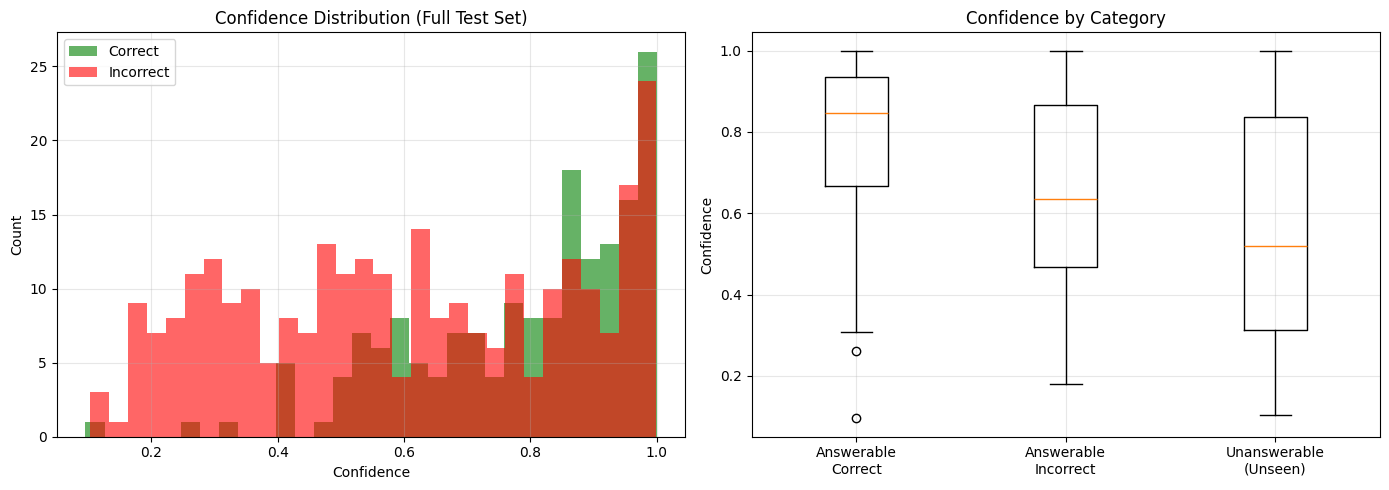


✓ Model shows lower confidence on unanswerable samples


In [ ]:
print("="*80)
print("PREDICTION CONFIDENCE ANALYSIS")
print("="*80)

# Get confidence scores
confidences = np.array([all_probabilities[i][all_predictions[i]] for i in range(len(all_predictions))])
correct_flags = (all_predictions == all_true_labels_eval)

# Full test set statistics
print("\n[FULL TEST SET]")
print(f"  Mean confidence: {confidences.mean():.4f}")
print(f"  Median confidence: {np.median(confidences):.4f}")
print(f"  Std confidence: {confidences.std():.4f}")

print(f"\n  Correct predictions: ({correct_flags.sum()} samples)")
print(f"    Mean confidence: {confidences[correct_flags].mean():.4f}")
print(f"  Incorrect predictions: ({(~correct_flags).sum()} samples)")
print(f"    Mean confidence: {confidences[~correct_flags].mean():.4f}")

print(f"\n  Answerable samples: ({answerable_mask.sum()} samples)")
print(f"    Mean confidence: {confidences[answerable_mask].mean():.4f}")
print(f"  Unanswerable samples: ({unseen_mask.sum()} samples)")
print(f"    Mean confidence: {confidences[unseen_mask].mean():.4f}")

# Answerable subset statistics
print("\n[ANSWERABLE SUBSET - Reference]")
ans_conf = confidences[answerable_mask]
ans_correct = correct_flags[answerable_mask]

print(f"  Mean confidence: {ans_conf.mean():.4f}")
print(f"  Correct predictions: ({ans_correct.sum()} samples)")
print(f"    Mean confidence: {ans_conf[ans_correct].mean():.4f}")
print(f"  Incorrect predictions: ({(~ans_correct).sum()} samples)")
print(f"    Mean confidence: {ans_conf[~ans_correct].mean():.4f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(confidences[correct_flags], bins=30, alpha=0.6, label='Correct', color='green')
ax1.hist(confidences[~correct_flags], bins=30, alpha=0.6, label='Incorrect', color='red')
ax1.set_xlabel('Confidence')
ax1.set_ylabel('Count')
ax1.set_title('Confidence Distribution (Full Test Set)')
ax1.legend()
ax1.grid(alpha=0.3)

# Box plot
ax2.boxplot([
    confidences[answerable_mask & correct_flags],
    confidences[answerable_mask & ~correct_flags],
    confidences[unseen_mask]
], labels=['Answerable\nCorrect', 'Answerable\nIncorrect', 'Unanswerable\n(Unseen)'])
ax2.set_ylabel('Confidence')
ax2.set_title('Confidence by Category')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Model shows lower confidence on unanswerable samples")
print("="*80)

### 6.6 Confusion Matrix (Top 10 Classes)

CONFUSION MATRIX (TOP 10 CLASSES)

Top 10 most frequent classes in test set:
  1. 'no' (class 231): 133 samples
  2. 'yes' (class 380): 118 samples
  3. 'axial' (class 35): 12 samples
  4. 'left' (class 172): 6 samples
  5. 'right' (class 289): 6 samples
  6. 'brain' (class 56): 5 samples
  7. 'right upper lobe' (class 319): 4 samples
  8. 'mri' (class 219): 4 samples
  9. 'female' (class 118): 4 samples
  10. 'right side' (class 310): 3 samples

Full Test Set



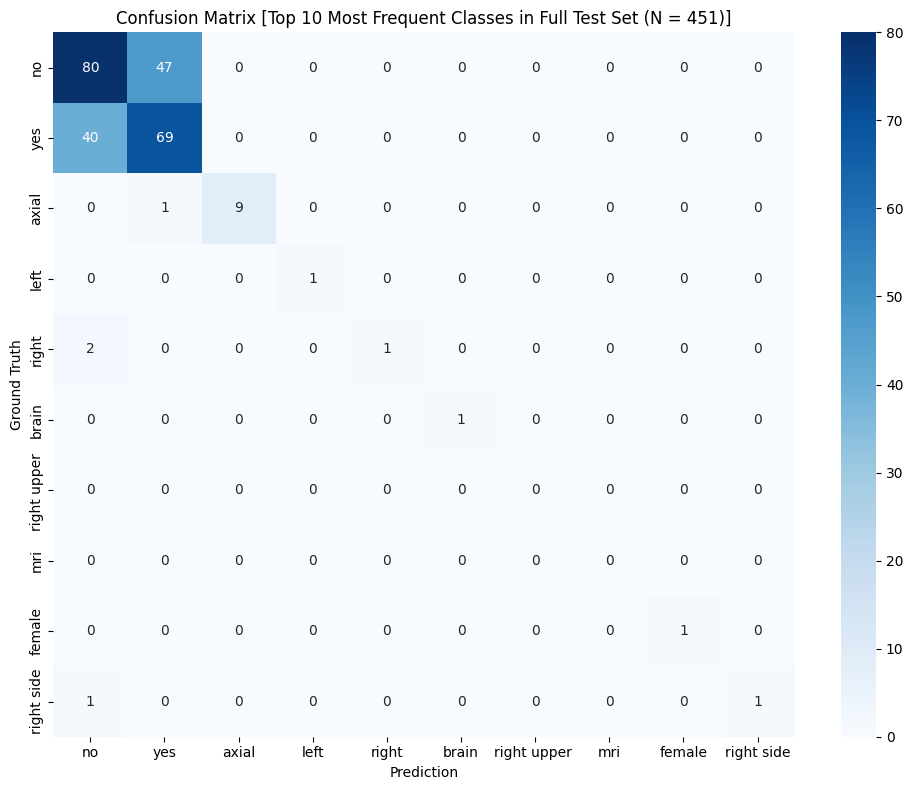


Answerable Test Subset



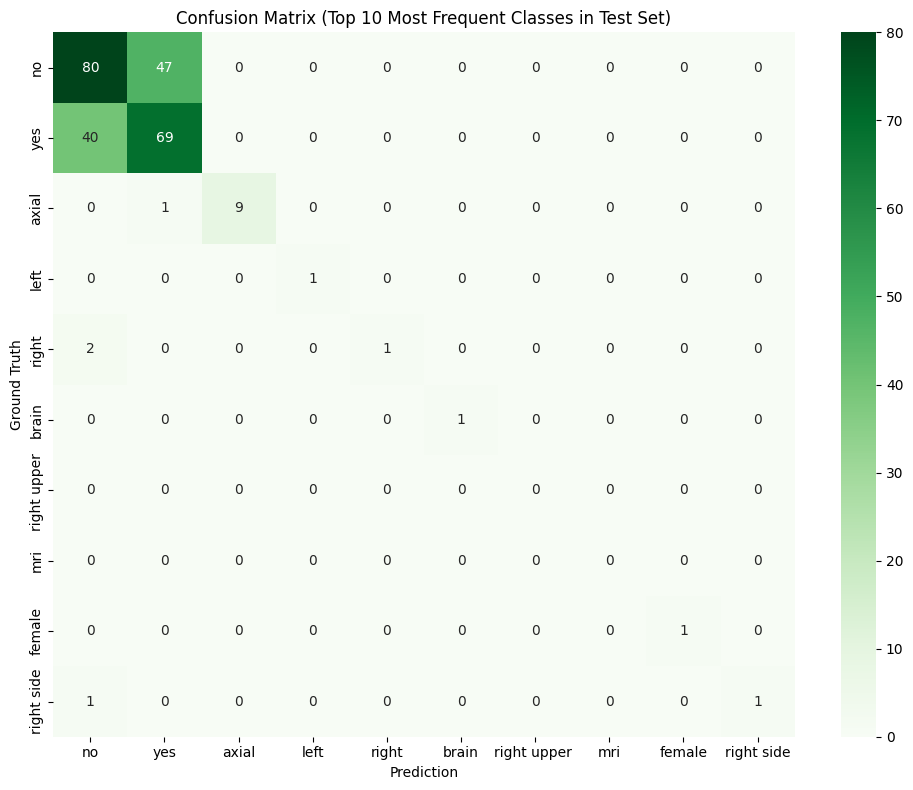

In [ ]:
print("="*80)
print("CONFUSION MATRIX (TOP 10 CLASSES)")
print("="*80)

# Get top 10 from full test set
test_answer_counts = pd.Series(all_true_answers).value_counts()
top_10_answers = test_answer_counts.head(10).index.tolist()

# Get class IDs (only for those in answer2idx)
top_10_ids = []
top_10_labels = []
for ans in top_10_answers:
    if ans in answer2idx:
        top_10_ids.append(answer2idx[ans])
        top_10_labels.append(ans)

print(f"\nTop 10 most frequent classes in test set:")
for i, (ans, idx) in enumerate(zip(top_10_labels, top_10_ids), 1):
    count = test_answer_counts[ans]
    print(f"  {i}. '{ans}' (class {idx}): {count} samples")

# Full test set confusion matrix
mask_full = np.isin(all_true_labels_eval, top_10_ids)
cm_full = confusion_matrix(
    all_true_labels_eval[mask_full],
    all_predictions[mask_full],
    labels=top_10_ids
)

# Answerable subset confusion matrix
mask_ans = np.isin(all_true_labels_eval[answerable_mask], top_10_ids)
cm_answerable = confusion_matrix(
    all_true_labels_eval[answerable_mask][mask_ans],
    all_predictions[answerable_mask][mask_ans],
    labels=top_10_ids
)

# PLOT FULL TEST SET MATRIX
print("\nFull Test Set\n")
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_full,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[ans[:12] for ans in top_10_labels],
    yticklabels=[ans[:12] for ans in top_10_labels]
)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title(f'Confusion Matrix [Top 10 Most Frequent Classes in Full Test Set (N = 451)]')
plt.tight_layout()
plt.show()  # Displays the first matrix

# PLOT ANSWERABLE SUBSET MATRIX
print("\nAnswerable Test Subset\n")
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_answerable,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=[ans[:12] for ans in top_10_labels],
    yticklabels=[ans[:12] for ans in top_10_labels]
)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title(f'Confusion Matrix [Top 10 Most Frequent Classes in Answerable Test Set (N = 333)]')
plt.tight_layout()
plt.show()  # Displays the second matrix

### 6.7 Macro Metrics

In [ ]:
print("="*80)
print("MACRO METRICS")
print("="*80)

# Full test set
macro_f1_full = f1_score(all_true_labels_eval, all_predictions, average='macro', zero_division=0)
macro_precision_full = precision_score(all_true_labels_eval, all_predictions, average='macro', zero_division=0)
macro_recall_full = recall_score(all_true_labels_eval, all_predictions, average='macro', zero_division=0)

# Answerable subset
macro_f1_ans = f1_score(
    all_true_labels_eval[answerable_mask],
    all_predictions[answerable_mask],
    average='macro', zero_division=0
)
macro_precision_ans = precision_score(
    all_true_labels_eval[answerable_mask],
    all_predictions[answerable_mask],
    average='macro', zero_division=0
)
macro_recall_ans = recall_score(
    all_true_labels_eval[answerable_mask],
    all_predictions[answerable_mask],
    average='macro', zero_division=0
)

print("\n[FULL TEST SET]")
print(f"  Macro F1-Score: {macro_f1_full:.4f}")
print(f"  Macro Precision: {macro_precision_full:.4f}")
print(f"  Macro Recall: {macro_recall_full:.4f}")

print("\n[ANSWERABLE SUBSET - Reference]")
print(f"  Macro F1-Score: {macro_f1_ans:.4f}")
print(f"  Macro Precision: {macro_precision_ans:.4f}")
print(f"  Macro Recall: {macro_recall_ans:.4f}")

print("="*80)

MACRO METRICS

[FULL TEST SET]
  Macro F1-Score: 0.0703
  Macro Precision: 0.0830
  Macro Recall: 0.0709

[ANSWERABLE SUBSET - Reference]
  Macro F1-Score: 0.1143
  Macro Precision: 0.1500
  Macro Recall: 0.1072


### 6.8 Per-Answer-Type Accuracy

In [ ]:
print("="*80)
print("PER-ANSWER-TYPE ACCURACY")
print("="*80)

# Create results dataframe (full test set)
df_test_results = df_test.copy()
df_test_results['predicted'] = all_predicted_answers
df_test_results['correct'] = [true == pred for true, pred in zip(all_true_answers, all_predicted_answers)]

# Full test set
answer_type_acc_full = df_test_results.groupby('answer_type')['correct'].mean()

# Answerable subset
df_test_answerable = df_test_results[answerable_mask].reset_index(drop=True)
answer_type_acc_ans = df_test_answerable.groupby('answer_type')['correct'].mean()

print("\n[FULL TEST SET]")
for atype, acc in answer_type_acc_full.sort_values(ascending=False).items():
    count = (df_test_results['answer_type'] == atype).sum()
    print(f"  {atype}: {acc:.4f} ({count} samples)")

print("\n[ANSWERABLE SUBSET - Reference]")
for atype, acc in answer_type_acc_ans.sort_values(ascending=False).items():
    count = (df_test_answerable['answer_type'] == atype).sum()
    print(f"  {atype}: {acc:.4f} ({count} samples)")

print("="*80)

PER-ANSWER-TYPE ACCURACY

[FULL TEST SET]
  CLOSED: 0.5588 (272 samples)
  OPEN: 0.1061 (179 samples)

[ANSWERABLE SUBSET - Reference]
  CLOSED: 0.5714 (266 samples)
  OPEN: 0.2836 (67 samples)


### 6.9 Per-Question-Type Accuracy

In [ ]:
print("="*80)
print("PER-QUESTION-TYPE ACCURACY")
print("="*80)

# Full test set
question_type_acc_full = df_test_results.groupby('question_type')['correct'].mean()

# Answerable subset
question_type_acc_ans = df_test_answerable.groupby('question_type')['correct'].mean()

print("\n[FULL TEST SET]")
for qtype, acc in question_type_acc_full.sort_values(ascending=False).items():
    count = (df_test_results['question_type'] == qtype).sum()
    print(f"  {qtype}: {acc:.4f} ({count} samples)")

print("\n[ANSWERABLE SUBSET - Reference]")
for qtype, acc in question_type_acc_ans.sort_values(ascending=False).items():
    count = (df_test_answerable['question_type'] == qtype).sum()
    print(f"  {qtype}: {acc:.4f} ({count} samples)")

print("="*80)

PER-QUESTION-TYPE ACCURACY

[FULL TEST SET]
  COLOR: 1.0000 (3 samples)
  COLOR, PRES: 1.0000 (1 samples)
  PRES, SIZE: 1.0000 (1 samples)
  PLANE: 0.6923 (26 samples)
  SIZE: 0.5778 (45 samples)
  PRES: 0.4417 (163 samples)
  MODALITY: 0.3636 (33 samples)
  ATTRIB: 0.3529 (17 samples)
  POS, PRES: 0.3333 (3 samples)
  ATTRIB, PRES: 0.3333 (3 samples)
  ORGAN: 0.3000 (10 samples)
  ABN: 0.2857 (56 samples)
  OTHER: 0.2692 (26 samples)
  POS: 0.0690 (58 samples)
  COUNT: 0.0000 (6 samples)

[ANSWERABLE SUBSET - Reference]
  COLOR: 1.0000 (3 samples)
  COLOR, PRES: 1.0000 (1 samples)
  PRES, SIZE: 1.0000 (1 samples)
  PLANE: 0.7500 (24 samples)
  SIZE: 0.6667 (39 samples)
  PRES: 0.5669 (127 samples)
  OTHER: 0.5385 (13 samples)
  POS, PRES: 0.5000 (2 samples)
  ATTRIB: 0.4615 (13 samples)
  MODALITY: 0.4615 (26 samples)
  ABN: 0.4324 (37 samples)
  ORGAN: 0.3750 (8 samples)
  ATTRIB, PRES: 0.3333 (3 samples)
  POS: 0.1333 (30 samples)
  COUNT: 0.0000 (6 samples)


### 6.10 Per-Image-Organ Accuracy

In [ ]:
print("="*80)
print("PER-IMAGE-ORGAN ACCURACY")
print("="*80)

# Full test set
organ_acc_full = df_test_results.groupby('image_organ')['correct'].mean()

# Answerable subset
organ_acc_ans = df_test_answerable.groupby('image_organ')['correct'].mean()

print("\n[FULL TEST SET]")
for organ, acc in organ_acc_full.sort_values(ascending=False).items():
    count = (df_test_results['image_organ'] == organ).sum()
    print(f"  {organ}: {acc:.4f} ({count} samples)")

print("\n[ANSWERABLE SUBSET - Reference]")
for organ, acc in organ_acc_ans.sort_values(ascending=False).items():
    count = (df_test_answerable['image_organ'] == organ).sum()
    print(f"  {organ}: {acc:.4f} ({count} samples)")

print("="*80)

PER-IMAGE-ORGAN ACCURACY

[FULL TEST SET]
  CHEST: 0.4310 (174 samples)
  ABD: 0.3544 (158 samples)
  HEAD: 0.3361 (119 samples)

[ANSWERABLE SUBSET - Reference]
  CHEST: 0.5515 (136 samples)
  HEAD: 0.4878 (82 samples)
  ABD: 0.4870 (115 samples)


### 6.11 BLEU Scores

In [ ]:
print("="*80)
print("BLEU SCORES")
print("="*80)

def compute_bleu_scores(references, hypotheses):
    smoothing = SmoothingFunction().method1
    bleu_scores = {}

    for n in range(1, 5):
        weights = tuple([1/n] * n + [0] * (4-n))
        scores = []
        for ref, hyp in zip(references, hypotheses):
            ref_tokens = [ref.lower().split()]
            hyp_tokens = hyp.lower().split()
            score = sentence_bleu(ref_tokens, hyp_tokens, weights=weights, smoothing_function=smoothing)
            scores.append(score)
        bleu_scores[f'BLEU-{n}'] = np.mean(scores)

    return bleu_scores

# Get answer types for all test samples (matches order of all_true_answers)
test_answer_types = df_test['answer_type'].values

# Create masks for CLOSED and OPEN
closed_mask_full = test_answer_types == 'CLOSED'
open_mask_full = test_answer_types == 'OPEN'

# Combine with answerable mask for answerable subsets
closed_mask_ans = answerable_mask & closed_mask_full
open_mask_ans = answerable_mask & open_mask_full

# ============================================================================
# FULL TEST SET
# ============================================================================

# All samples
bleu_scores_full_all = compute_bleu_scores(all_true_answers, all_predicted_answers)

# CLOSED only
true_ans_full_closed = [ans for ans, mask in zip(all_true_answers, closed_mask_full) if mask]
pred_ans_full_closed = [ans for ans, mask in zip(all_predicted_answers, closed_mask_full) if mask]
bleu_scores_full_closed = compute_bleu_scores(true_ans_full_closed, pred_ans_full_closed)

# OPEN only
true_ans_full_open = [ans for ans, mask in zip(all_true_answers, open_mask_full) if mask]
pred_ans_full_open = [ans for ans, mask in zip(all_predicted_answers, open_mask_full) if mask]
bleu_scores_full_open = compute_bleu_scores(true_ans_full_open, pred_ans_full_open)

# ============================================================================
# ANSWERABLE SUBSET
# ============================================================================

# All answerable
true_ans_answerable_all = [ans for ans, mask in zip(all_true_answers, answerable_mask) if mask]
pred_ans_answerable_all = [ans for ans, mask in zip(all_predicted_answers, answerable_mask) if mask]
bleu_scores_ans_all = compute_bleu_scores(true_ans_answerable_all, pred_ans_answerable_all)

# CLOSED answerable only
true_ans_ans_closed = [ans for ans, mask in zip(all_true_answers, closed_mask_ans) if mask]
pred_ans_ans_closed = [ans for ans, mask in zip(all_predicted_answers, closed_mask_ans) if mask]
bleu_scores_ans_closed = compute_bleu_scores(true_ans_ans_closed, pred_ans_ans_closed)

# OPEN answerable only
true_ans_ans_open = [ans for ans, mask in zip(all_true_answers, open_mask_ans) if mask]
pred_ans_ans_open = [ans for ans, mask in zip(all_predicted_answers, open_mask_ans) if mask]
bleu_scores_ans_open = compute_bleu_scores(true_ans_ans_open, pred_ans_ans_open)

# ============================================================================
# DISPLAY
# ============================================================================

print("\n" + "="*80)
print("FULL TEST SET")
print("="*80)

print(f"\n[ALL] (N={len(all_true_answers)})")
for metric, score in bleu_scores_full_all.items():
    print(f"  {metric}: {score:.4f}")

print(f"\n[CLOSED ONLY] (N={len(true_ans_full_closed)})")
for metric, score in bleu_scores_full_closed.items():
    print(f"  {metric}: {score:.4f}")

print(f"\n[OPEN ONLY] (N={len(true_ans_full_open)})")
for metric, score in bleu_scores_full_open.items():
    print(f"  {metric}: {score:.4f}")

print("\n" + "="*80)
print("ANSWERABLE SUBSET - Reference")
print("="*80)

print(f"\n[ALL ANSWERABLE] (N={len(true_ans_answerable_all)})")
for metric, score in bleu_scores_ans_all.items():
    print(f"  {metric}: {score:.4f}")

print(f"\n[CLOSED ANSWERABLE] (N={len(true_ans_ans_closed)})")
for metric, score in bleu_scores_ans_closed.items():
    print(f"  {metric}: {score:.4f}")

print(f"\n[OPEN ANSWERABLE] (N={len(true_ans_ans_open)})")
for metric, score in bleu_scores_ans_open.items():
    print(f"  {metric}: {score:.4f}")

print("="*80)

BLEU SCORES

FULL TEST SET

[ALL] (N=451)
  BLEU-1: 0.3927
  BLEU-2: 0.1311
  BLEU-3: 0.0889
  BLEU-4: 0.0726

[CLOSED ONLY] (N=272)
  BLEU-1: 0.5607
  BLEU-2: 0.1801
  BLEU-3: 0.1219
  BLEU-4: 0.1004

[OPEN ONLY] (N=179)
  BLEU-1: 0.1376
  BLEU-2: 0.0566
  BLEU-3: 0.0388
  BLEU-4: 0.0303

ANSWERABLE SUBSET - Reference

[ALL ANSWERABLE] (N=333)
  BLEU-1: 0.5206
  BLEU-2: 0.1716
  BLEU-3: 0.1168
  BLEU-4: 0.0953

[CLOSED ANSWERABLE] (N=266)
  BLEU-1: 0.5733
  BLEU-2: 0.1841
  BLEU-3: 0.1247
  BLEU-4: 0.1027

[OPEN ANSWERABLE] (N=67)
  BLEU-1: 0.3115
  BLEU-2: 0.1218
  BLEU-3: 0.0854
  BLEU-4: 0.0659


### 6.12 Wu-Palmer Similarity Score (WBSS)

In [ ]:
print("="*80)
print("WU-PALMER SIMILARITY SCORE (WBSS)")
print("="*80)

def wu_palmer_similarity(true_ans, pred_ans):
    try:
        true_synsets = wn.synsets(true_ans.replace(' ', '_'))
        pred_synsets = wn.synsets(pred_ans.replace(' ', '_'))

        if not true_synsets or not pred_synsets:
            return 0.0

        max_sim = 0
        for ts in true_synsets:
            for ps in pred_synsets:
                sim = ts.wup_similarity(ps)
                if sim and sim > max_sim:
                    max_sim = sim
        return max_sim
    except:
        return 0.0

def compute_wbss(true_answers, pred_answers, accuracy):
    """Compute WBSS scores"""
    wbss_scores = []
    for true_ans, pred_ans in zip(true_answers, pred_answers):
        if true_ans == pred_ans:
            wbss_scores.append(1.0)
        else:
            sim = wu_palmer_similarity(true_ans, pred_ans)
            wbss_scores.append(sim)

    mean_wbss = np.mean(wbss_scores)
    median_wbss = np.median(wbss_scores)
    semantic_gain = (mean_wbss - accuracy) * 100

    return mean_wbss, median_wbss, semantic_gain

# Calculate accuracies for each category
acc_full_all = overall_acc_full
acc_full_closed = sum([t == p for t, p in zip(true_ans_full_closed, pred_ans_full_closed)]) / len(true_ans_full_closed)
acc_full_open = sum([t == p for t, p in zip(true_ans_full_open, pred_ans_full_open)]) / len(true_ans_full_open)

acc_ans_all = overall_acc_answerable
acc_ans_closed = sum([t == p for t, p in zip(true_ans_ans_closed, pred_ans_ans_closed)]) / len(true_ans_ans_closed)
acc_ans_open = sum([t == p for t, p in zip(true_ans_ans_open, pred_ans_ans_open)]) / len(true_ans_ans_open)

# ============================================================================
# COMPUTE WBSS
# ============================================================================

# FULL TEST SET
mean_wbss_full_all, median_wbss_full_all, gain_full_all = compute_wbss(
    all_true_answers, all_predicted_answers, acc_full_all
)

mean_wbss_full_closed, median_wbss_full_closed, gain_full_closed = compute_wbss(
    true_ans_full_closed, pred_ans_full_closed, acc_full_closed
)

mean_wbss_full_open, median_wbss_full_open, gain_full_open = compute_wbss(
    true_ans_full_open, pred_ans_full_open, acc_full_open
)

# ANSWERABLE SUBSET
mean_wbss_ans_all, median_wbss_ans_all, gain_ans_all = compute_wbss(
    true_ans_answerable_all, pred_ans_answerable_all, acc_ans_all
)

mean_wbss_ans_closed, median_wbss_ans_closed, gain_ans_closed = compute_wbss(
    true_ans_ans_closed, pred_ans_ans_closed, acc_ans_closed
)

mean_wbss_ans_open, median_wbss_ans_open, gain_ans_open = compute_wbss(
    true_ans_ans_open, pred_ans_ans_open, acc_ans_open
)

# ============================================================================
# DISPLAY
# ============================================================================

print("\n" + "="*80)
print("FULL TEST SET")
print("="*80)

print(f"\n[ALL] (N={len(all_true_answers)})")
print(f"  Mean WBSS: {mean_wbss_full_all:.4f}")
print(f"  Median WBSS: {median_wbss_full_all:.4f}")
print(f"  Exact match: {acc_full_all:.4f}")
print(f"  Semantic gain: +{gain_full_all:.1f}%")

print(f"\n[CLOSED ONLY] (N={len(true_ans_full_closed)})")
print(f"  Mean WBSS: {mean_wbss_full_closed:.4f}")
print(f"  Median WBSS: {median_wbss_full_closed:.4f}")
print(f"  Exact match: {acc_full_closed:.4f}")
print(f"  Semantic gain: +{gain_full_closed:.1f}%")

print(f"\n[OPEN ONLY] (N={len(true_ans_full_open)})")
print(f"  Mean WBSS: {mean_wbss_full_open:.4f}")
print(f"  Median WBSS: {median_wbss_full_open:.4f}")
print(f"  Exact match: {acc_full_open:.4f}")
print(f"  Semantic gain: +{gain_full_open:.1f}%")

print("\n" + "="*80)
print("ANSWERABLE SUBSET - Reference")
print("="*80)

print(f"\n[ALL ANSWERABLE] (N={len(true_ans_answerable_all)})")
print(f"  Mean WBSS: {mean_wbss_ans_all:.4f}")
print(f"  Median WBSS: {median_wbss_ans_all:.4f}")
print(f"  Exact match: {acc_ans_all:.4f}")
print(f"  Semantic gain: +{gain_ans_all:.1f}%")

print(f"\n[CLOSED ANSWERABLE] (N={len(true_ans_ans_closed)})")
print(f"  Mean WBSS: {mean_wbss_ans_closed:.4f}")
print(f"  Median WBSS: {median_wbss_ans_closed:.4f}")
print(f"  Exact match: {acc_ans_closed:.4f}")
print(f"  Semantic gain: +{gain_ans_closed:.1f}%")

print(f"\n[OPEN ANSWERABLE] (N={len(true_ans_ans_open)})")
print(f"  Mean WBSS: {mean_wbss_ans_open:.4f}")
print(f"  Median WBSS: {median_wbss_ans_open:.4f}")
print(f"  Exact match: {acc_ans_open:.4f}")
print(f"  Semantic gain: +{gain_ans_open:.1f}%")

print("="*80)

WU-PALMER SIMILARITY SCORE (WBSS)

FULL TEST SET

[ALL] (N=451)
  Mean WBSS: 0.4451
  Median WBSS: 0.2353
  Exact match: 0.3792
  Semantic gain: +6.6%

[CLOSED ONLY] (N=272)
  Mean WBSS: 0.6501
  Median WBSS: 1.0000
  Exact match: 0.5588
  Semantic gain: +9.1%

[OPEN ONLY] (N=179)
  Mean WBSS: 0.1335
  Median WBSS: 0.0000
  Exact match: 0.1061
  Semantic gain: +2.7%

ANSWERABLE SUBSET - Reference

[ALL ANSWERABLE] (N=333)
  Mean WBSS: 0.5968
  Median WBSS: 1.0000
  Exact match: 0.5135
  Semantic gain: +8.3%

[CLOSED ANSWERABLE] (N=266)
  Mean WBSS: 0.6623
  Median WBSS: 1.0000
  Exact match: 0.5714
  Semantic gain: +9.1%

[OPEN ANSWERABLE] (N=67)
  Mean WBSS: 0.3367
  Median WBSS: 0.0000
  Exact match: 0.2836
  Semantic gain: +5.3%


### 6.13 Comprehensive Summary

In [ ]:
print("="*80)
print("COMPREHENSIVE EVALUATION SUMMARY")
print("="*80)

print("\n[TEST SET COMPOSITION]")
print(f"  Total test samples: {len(df_test)}")
print(f"  CLOSED-ended: {closed_mask_full.sum()} ({closed_mask_full.sum()/len(df_test)*100:.1f}%)")
print(f"  OPEN-ended: {open_mask_full.sum()} ({open_mask_full.sum()/len(df_test)*100:.1f}%)")
print(f"  Answerable (seen answers): {num_answerable} ({num_answerable/len(df_test)*100:.1f}%)")
print(f"  Unanswerable (unseen): {num_unseen} ({num_unseen/len(df_test)*100:.1f}%)")

# ============================================================================
# FULL TEST SET - ALL
# ============================================================================
print("\n" + "="*80)
print("FULL TEST SET - ALL (CLOSED + OPEN)")
print("="*80)

print(f"\n[OVERALL] (N={len(all_true_answers)})")
print(f"  Accuracy: {overall_acc_full:.4f} ({correct_full}/{len(df_test)} correct)")

print(f"\n[MACRO METRICS]")
print(f"  F1-Score: {macro_f1_full:.4f}")
print(f"  Precision: {macro_precision_full:.4f}")
print(f"  Recall: {macro_recall_full:.4f}")

print(f"\n[BLEU SCORES]")
for metric, score in bleu_scores_full_all.items():
    print(f"  {metric}: {score:.4f}")

print(f"\n[SEMANTIC SIMILARITY]")
print(f"  Mean WBSS: {mean_wbss_full_all:.4f}")
print(f"  Median WBSS: {median_wbss_full_all:.4f}")
print(f"  Semantic gain: +{gain_full_all:.1f}%")

print(f"\n[PER-CATEGORY ACCURACY]")
print("  Answer Type:")
for atype, acc in answer_type_acc_full.sort_values(ascending=False).items():
    print(f"    {atype}: {acc:.4f}")

print("\n  Question Type (ALL):")
for qtype, acc in question_type_acc_full.sort_values(ascending=False).items():
    print(f"    {qtype}: {acc:.4f}")

print("\n  Image Organ:")
for organ, acc in organ_acc_full.sort_values(ascending=False).items():
    print(f"    {organ}: {acc:.4f}")

# ============================================================================
# FULL TEST SET - CLOSED ONLY
# ============================================================================
print("\n" + "="*80)
print("FULL TEST SET - CLOSED-ENDED ONLY")
print("="*80)

print(f"\n[OVERALL] (N={len(true_ans_full_closed)})")
print(f"  Accuracy: {acc_full_closed:.4f}")

print(f"\n[BLEU SCORES]")
for metric, score in bleu_scores_full_closed.items():
    print(f"  {metric}: {score:.4f}")

print(f"\n[SEMANTIC SIMILARITY]")
print(f"  Mean WBSS: {mean_wbss_full_closed:.4f}")
print(f"  Median WBSS: {median_wbss_full_closed:.4f}")
print(f"  Semantic gain: +{gain_full_closed:.1f}%")

# ============================================================================
# FULL TEST SET - OPEN ONLY
# ============================================================================
print("\n" + "="*80)
print("FULL TEST SET - OPEN-ENDED ONLY")
print("="*80)

print(f"\n[OVERALL] (N={len(true_ans_full_open)})")
print(f"  Accuracy: {acc_full_open:.4f}")

print(f"\n[BLEU SCORES]")
for metric, score in bleu_scores_full_open.items():
    print(f"  {metric}: {score:.4f}")

print(f"\n[SEMANTIC SIMILARITY]")
print(f"  Mean WBSS: {mean_wbss_full_open:.4f}")
print(f"  Median WBSS: {median_wbss_full_open:.4f}")
print(f"  Semantic gain: +{gain_full_open:.1f}%")

# ============================================================================
# ANSWERABLE SUBSET - ALL
# ============================================================================
print("\n" + "="*80)
print("ANSWERABLE SUBSET - ALL (Reference)")
print("="*80)

print(f"\n[OVERALL] (N={len(true_ans_answerable_all)})")
print(f"  Accuracy: {overall_acc_answerable:.4f} ({correct_answerable}/{num_answerable} correct)")

print(f"\n[MACRO METRICS]")
print(f"  F1-Score: {macro_f1_ans:.4f}")
print(f"  Precision: {macro_precision_ans:.4f}")
print(f"  Recall: {macro_recall_ans:.4f}")

print(f"\n[BLEU SCORES]")
for metric, score in bleu_scores_ans_all.items():
    print(f"  {metric}: {score:.4f}")

print(f"\n[SEMANTIC SIMILARITY]")
print(f"  Mean WBSS: {mean_wbss_ans_all:.4f}")
print(f"  Median WBSS: {median_wbss_ans_all:.4f}")
print(f"  Semantic gain: +{gain_ans_all:.1f}%")

print(f"\n[PER-CATEGORY ACCURACY]")
print("  Answer Type:")
for atype, acc in answer_type_acc_ans.sort_values(ascending=False).items():
    print(f"    {atype}: {acc:.4f}")

print("\n  Question Type (ALL):")
for qtype, acc in question_type_acc_ans.sort_values(ascending=False).items():
    print(f"    {qtype}: {acc:.4f}")

print("\n  Image Organ:")
for organ, acc in organ_acc_ans.sort_values(ascending=False).items():
    print(f"    {organ}: {acc:.4f}")

# ============================================================================
# ANSWERABLE SUBSET - CLOSED ONLY
# ============================================================================
print("\n" + "="*80)
print("ANSWERABLE SUBSET - CLOSED-ENDED ONLY (Reference)")
print("="*80)

print(f"\n[OVERALL] (N={len(true_ans_ans_closed)})")
print(f"  Accuracy: {acc_ans_closed:.4f}")

print(f"\n[BLEU SCORES]")
for metric, score in bleu_scores_ans_closed.items():
    print(f"  {metric}: {score:.4f}")

print(f"\n[SEMANTIC SIMILARITY]")
print(f"  Mean WBSS: {mean_wbss_ans_closed:.4f}")
print(f"  Median WBSS: {median_wbss_ans_closed:.4f}")
print(f"  Semantic gain: +{gain_ans_closed:.1f}%")

# ============================================================================
# ANSWERABLE SUBSET - OPEN ONLY
# ============================================================================
print("\n" + "="*80)
print("ANSWERABLE SUBSET - OPEN-ENDED ONLY (Reference)")
print("="*80)

print(f"\n[OVERALL] (N={len(true_ans_ans_open)})")
print(f"  Accuracy: {acc_ans_open:.4f}")

print(f"\n[BLEU SCORES]")
for metric, score in bleu_scores_ans_open.items():
    print(f"  {metric}: {score:.4f}")

print(f"\n[SEMANTIC SIMILARITY]")
print(f"  Mean WBSS: {mean_wbss_ans_open:.4f}")
print(f"  Median WBSS: {median_wbss_ans_open:.4f}")
print(f"  Semantic gain: +{gain_ans_open:.1f}%")

print("\n" + "="*80)

COMPREHENSIVE EVALUATION SUMMARY

[TEST SET COMPOSITION]
  Total test samples: 451
  CLOSED-ended: 272 (60.3%)
  OPEN-ended: 179 (39.7%)
  Answerable (seen answers): 333 (73.8%)
  Unanswerable (unseen): 118 (26.2%)

FULL TEST SET - ALL (CLOSED + OPEN)

[OVERALL] (N=451)
  Accuracy: 0.3792 (171/451 correct)

[MACRO METRICS]
  F1-Score: 0.0703
  Precision: 0.0830
  Recall: 0.0709

[BLEU SCORES]
  BLEU-1: 0.3927
  BLEU-2: 0.1311
  BLEU-3: 0.0889
  BLEU-4: 0.0726

[SEMANTIC SIMILARITY]
  Mean WBSS: 0.4451
  Median WBSS: 0.2353
  Semantic gain: +6.6%

[PER-CATEGORY ACCURACY]
  Answer Type:
    CLOSED: 0.5588
    OPEN: 0.1061

  Question Type (ALL):
    COLOR: 1.0000
    COLOR, PRES: 1.0000
    PRES, SIZE: 1.0000
    PLANE: 0.6923
    SIZE: 0.5778
    PRES: 0.4417
    MODALITY: 0.3636
    ATTRIB: 0.3529
    POS, PRES: 0.3333
    ATTRIB, PRES: 0.3333
    ORGAN: 0.3000
    ABN: 0.2857
    OTHER: 0.2692
    POS: 0.0690
    COUNT: 0.0000

  Image Organ:
    CHEST: 0.4310
    ABD: 0.3544
    HEAD

---
## 🔍 Section 7: Inference & Visualization

**Purpose**: Test the model on sample images and visualize attention maps

### 7.1 Inference Function

In [ ]:
def predict_with_attention(model, image_path, question_text, word2idx, idx2answer, transform, device, max_length=23):
    """
    Predict answer and get attention weights for visualization.
    """
    model.eval()

    # Load and transform image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)  # (1, 3, 224, 224)

    # Encode question
    words = question_text.lower().split()
    indices = [word2idx.get(word, word2idx['<UNK>']) for word in words]
    actual_length = len(indices)

    # Pad
    if len(indices) < max_length:
        indices += [word2idx['<PAD>']] * (max_length - len(indices))
    else:
        indices = indices[:max_length]
        actual_length = max_length

    question_tensor = torch.LongTensor([indices]).to(device)  # (1, max_length)
    question_length = torch.LongTensor([actual_length])

    # Predict
    with torch.no_grad():
        logits, attention_weights = model(image_tensor, question_tensor, question_length)
        prediction = logits.argmax(dim=1).item()
        predicted_answer = idx2answer[prediction]

        # Get top-5 predictions
        probs = F.softmax(logits, dim=1)
        top5_probs, top5_indices = torch.topk(probs, 5)
        top5_answers = [(idx2answer[idx.item()], prob.item())
                        for idx, prob in zip(top5_indices[0], top5_probs[0])]

    return {
        'predicted_answer': predicted_answer,
        'top5_answers': top5_answers,
        'attention_weights': attention_weights,  # List of attention maps for each layer
        'image': image
    }

print("✓ Inference function defined")
print("  Returns: predicted answer, top-5, attention weights (list), image")

✓ Inference function defined
  Returns: predicted answer, top-5, attention weights (list), image


### 7.2 Attention Visualization

In [ ]:
def visualize_attention(image, attention_weights, question, predicted_answer, true_answer=None):
    """
    Visualize attention heatmap overlaid on image.
    Uses last attention layer (most refined).
    """
    # Get last attention layer weights (most refined)
    attn = attention_weights[-1][0].cpu().numpy()  # (196,)

    # Reshape to 14x14 spatial grid
    attn_map = attn.reshape(14, 14)

    # Resize to image size
    attn_map_resized = np.array(Image.fromarray(attn_map).resize(
        image.size, Image.BILINEAR
    ))

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Original image
    axes[0].imshow(image)
    axes[0].set_title('Original Image', fontsize=14)
    axes[0].axis('off')

    # Attention heatmap
    axes[1].imshow(attn_map, cmap='hot', interpolation='bilinear')
    axes[1].set_title('Attention Heatmap (14×14)', fontsize=14)
    axes[1].axis('off')

    # Overlay
    axes[2].imshow(image)
    axes[2].imshow(attn_map_resized, cmap='hot', alpha=0.5, interpolation='bilinear')
    axes[2].set_title('Attention Overlay', fontsize=14)
    axes[2].axis('off')

    # Add text
    title = f"Q: {question}\n"
    title += f"Predicted: {predicted_answer}"
    if true_answer:
        correct = "✓" if predicted_answer == true_answer else "✗"
        title += f" | True: {true_answer} {correct}"

    fig.suptitle(title, fontsize=12, y=0.95)
    plt.tight_layout()
    plt.show()

print("✓ Visualization function defined")
print("  Uses last attention layer for refined visualization")

✓ Visualization function defined
  Uses last attention layer for refined visualization


### 7.3 Sample Predictions with Attention

SAMPLE PREDICTIONS WITH ATTENTION VISUALIZATION
Showing 10 sample predictions:
  CLOSED answer type: 5 samples
  OPEN answer type: 5 samples

Sample 1:
  Image: synpic42202.jpg
  Question: is there evidence of an aortic aneurysm
  Answer Type: CLOSED
  Image Organ: CHEST
  Question Type: PRES
  True answer: yes
  Predicted: no
  Correct: False ✗
  Top 5 predictions:
    no: 0.9695
    yes: 0.0225
    chest x ray: 0.0027
    cardiovascular: 0.0012
    5 6cm focal predominantly hypodense: 0.0002


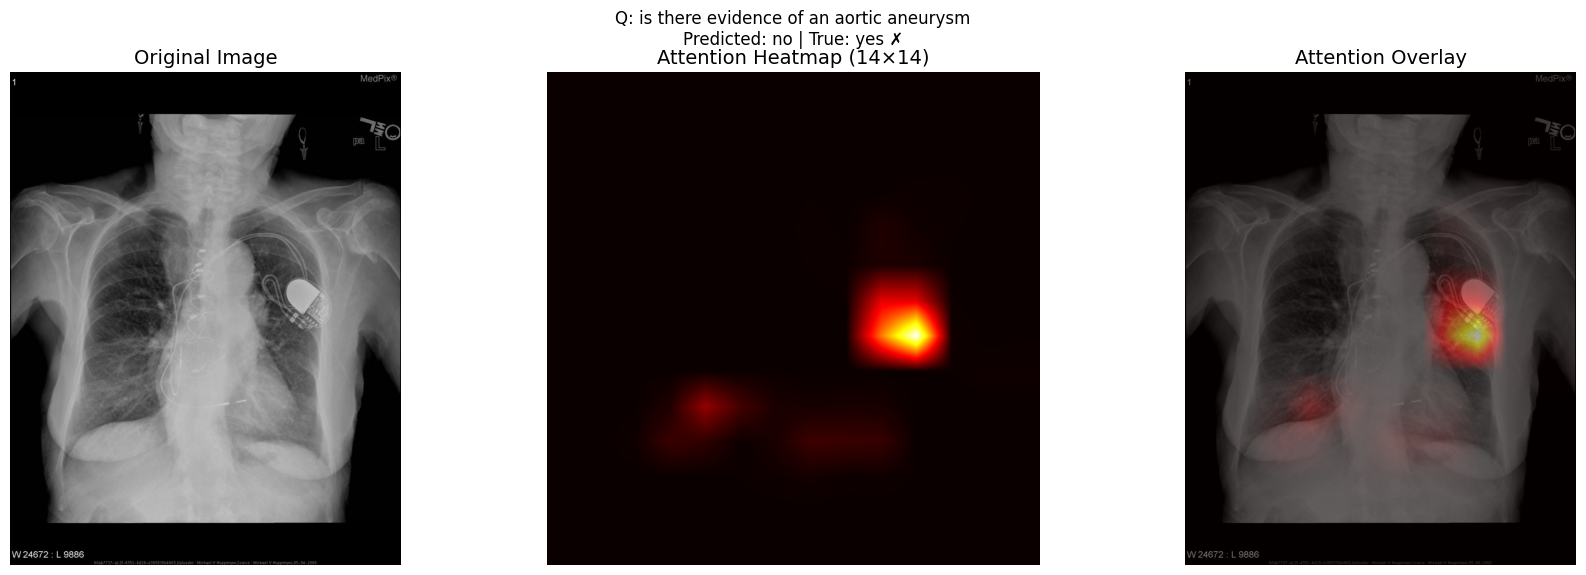

--------------------------------------------------------------------------------
Sample 2:
  Image: synpic39532.jpg
  Question: is there a pneumothorax present
  Answer Type: CLOSED
  Image Organ: CHEST
  Question Type: PRES
  True answer: no
  Predicted: no
  Correct: True ✓
  Top 5 predictions:
    no: 0.9822
    yes: 0.0150
    right lower lobe: 0.0015
    necrotic tissue: 0.0003
    lung markings present all the way laterally to the ribs: 0.0003


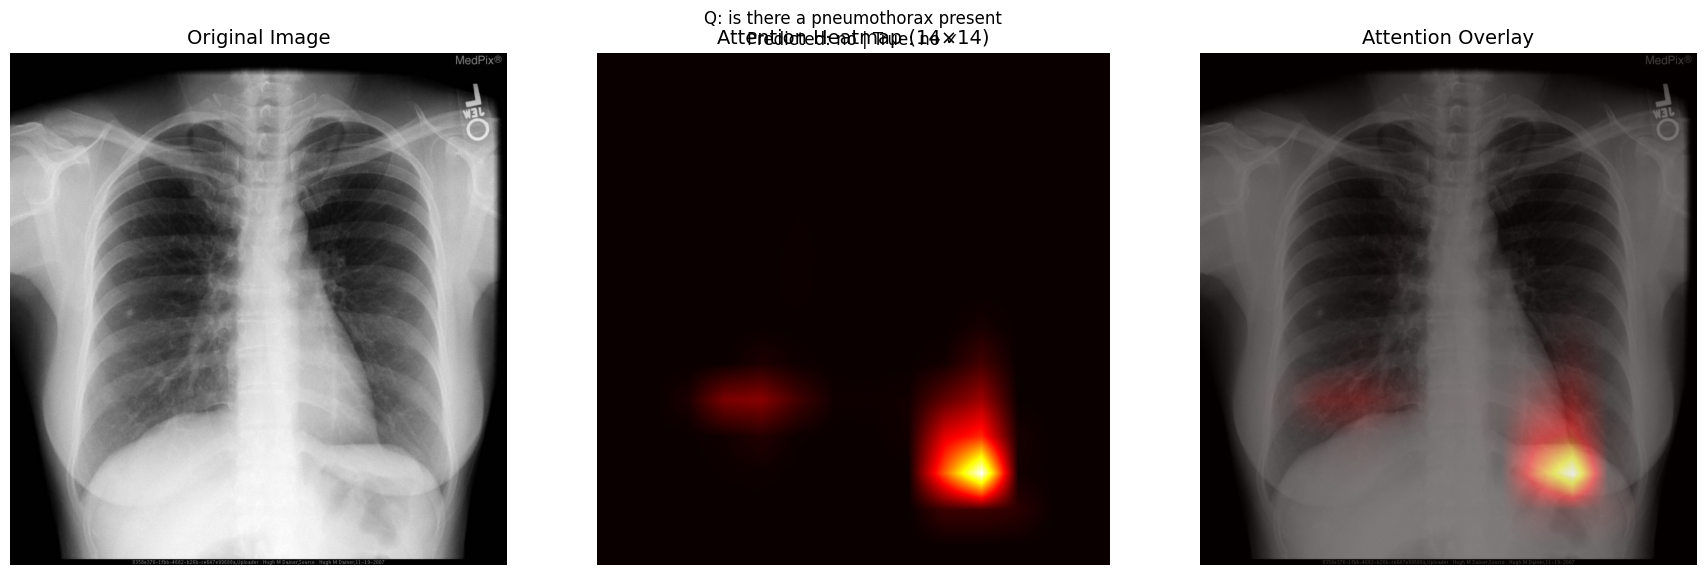

--------------------------------------------------------------------------------
Sample 3:
  Image: synpic56388.jpg
  Question: is the brain swollen
  Answer Type: CLOSED
  Image Organ: HEAD
  Question Type: PRES
  True answer: yes
  Predicted: yes
  Correct: True ✓
  Top 5 predictions:
    yes: 0.8660
    no: 0.1235
    right side: 0.0022
    anterior surface: 0.0014
    posterior fossa: 0.0006


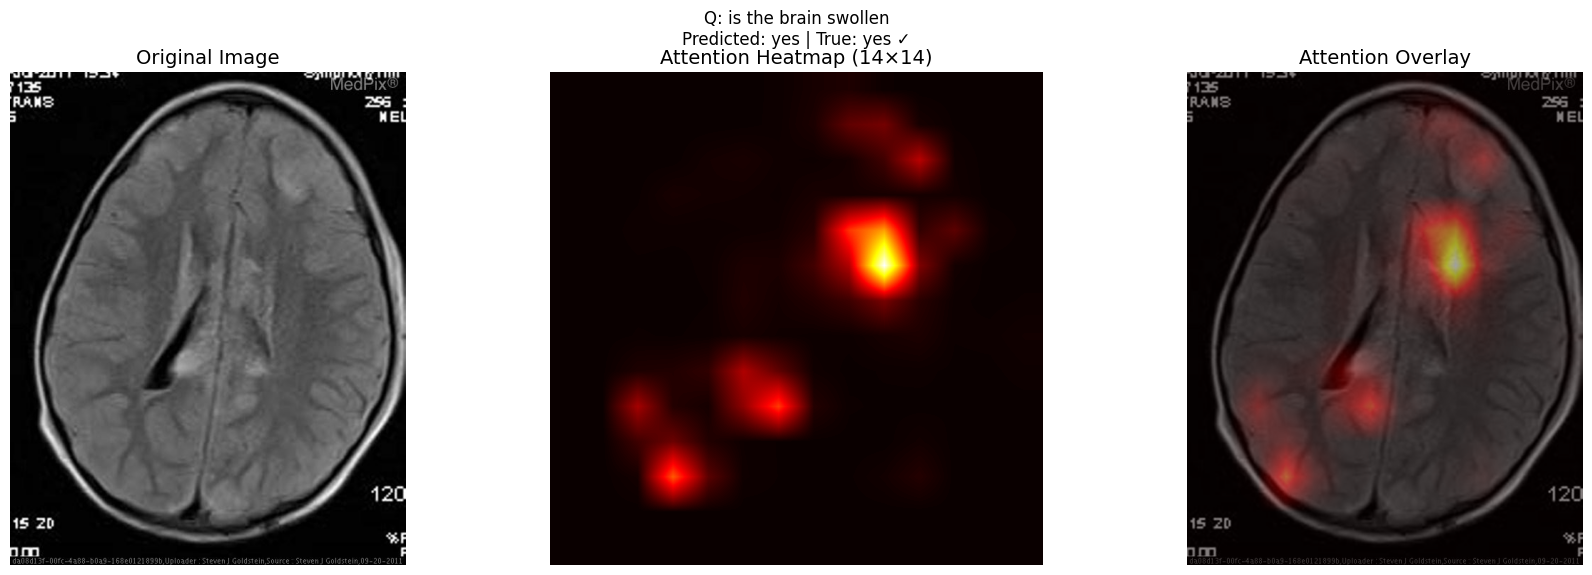

--------------------------------------------------------------------------------
Sample 4:
  Image: synpic45610.jpg
  Question: is the diaphragm flat on either side
  Answer Type: CLOSED
  Image Organ: CHEST
  Question Type: ATTRIB
  True answer: no
  Predicted: no
  Correct: True ✓
  Top 5 predictions:
    no: 0.9102
    right: 0.0302
    right side: 0.0279
    yes: 0.0229
    right sided aortic arch: 0.0020


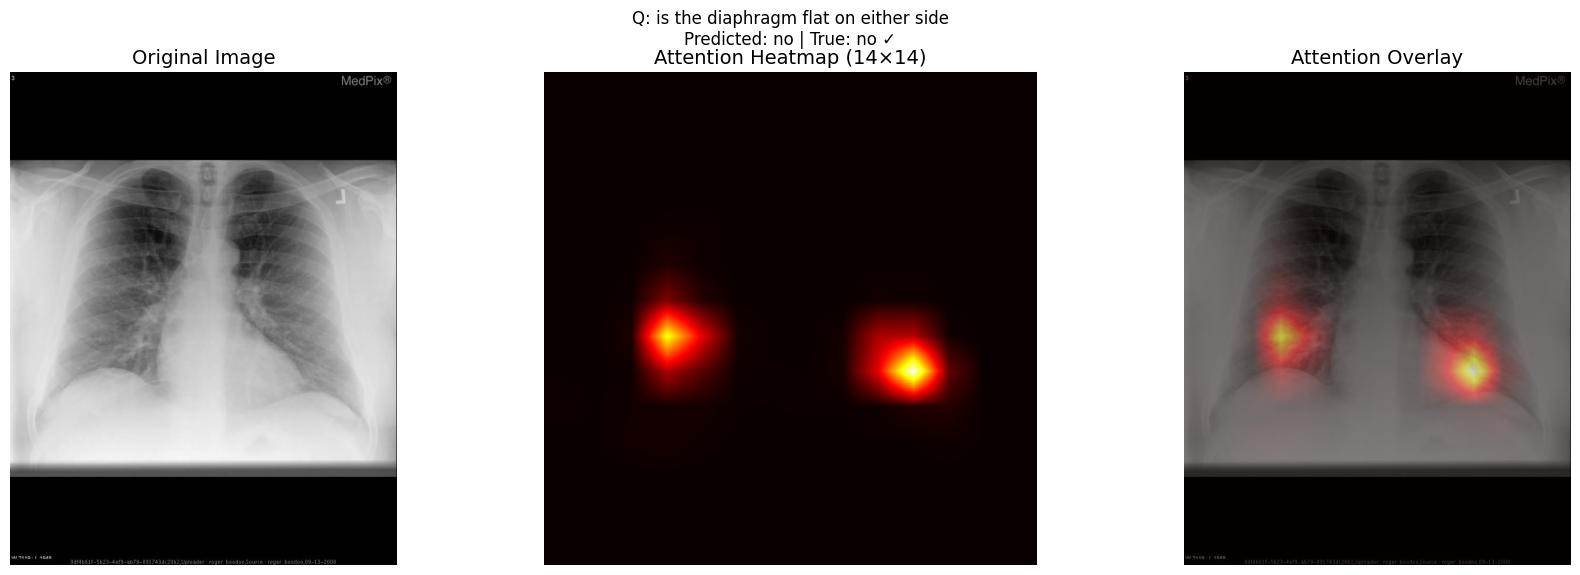

--------------------------------------------------------------------------------
Sample 5:
  Image: synpic39088.jpg
  Question: is there evidence of pneumoperitoneum
  Answer Type: CLOSED
  Image Organ: ABD
  Question Type: PRES
  True answer: yes
  Predicted: no
  Correct: False ✗
  Top 5 predictions:
    no: 0.9138
    yes: 0.0847
    abscess: 0.0002
    sharp costophrenic angles: 0.0001
    4th ventricle: 0.0001


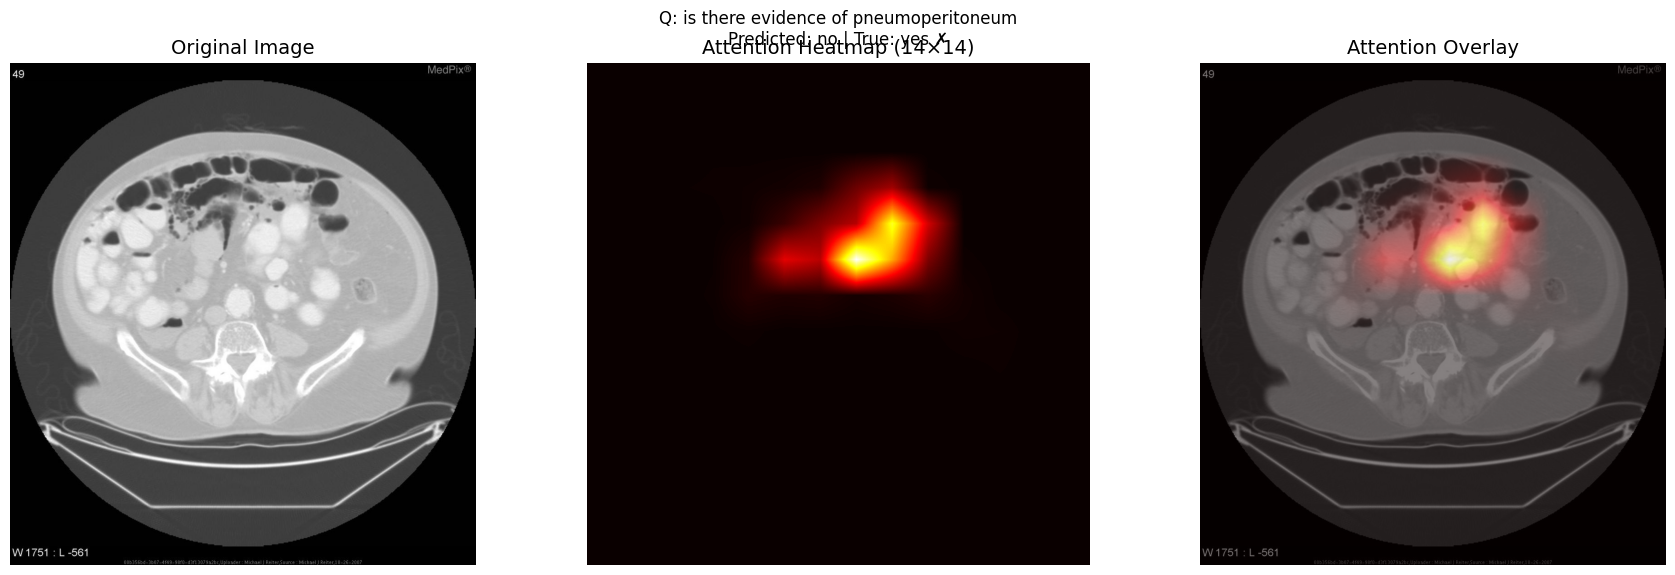

--------------------------------------------------------------------------------
Sample 6:
  Image: synpic49914.jpg
  Question: which plane is this image taken
  Answer Type: OPEN
  Image Organ: CHEST
  Question Type: PLANE
  True answer: pa
  Predicted: pa
  Correct: True ✓
  Top 5 predictions:
    pa: 0.8880
    axial: 0.1094
    x ray: 0.0012
    brain: 0.0004
    mri: 0.0002


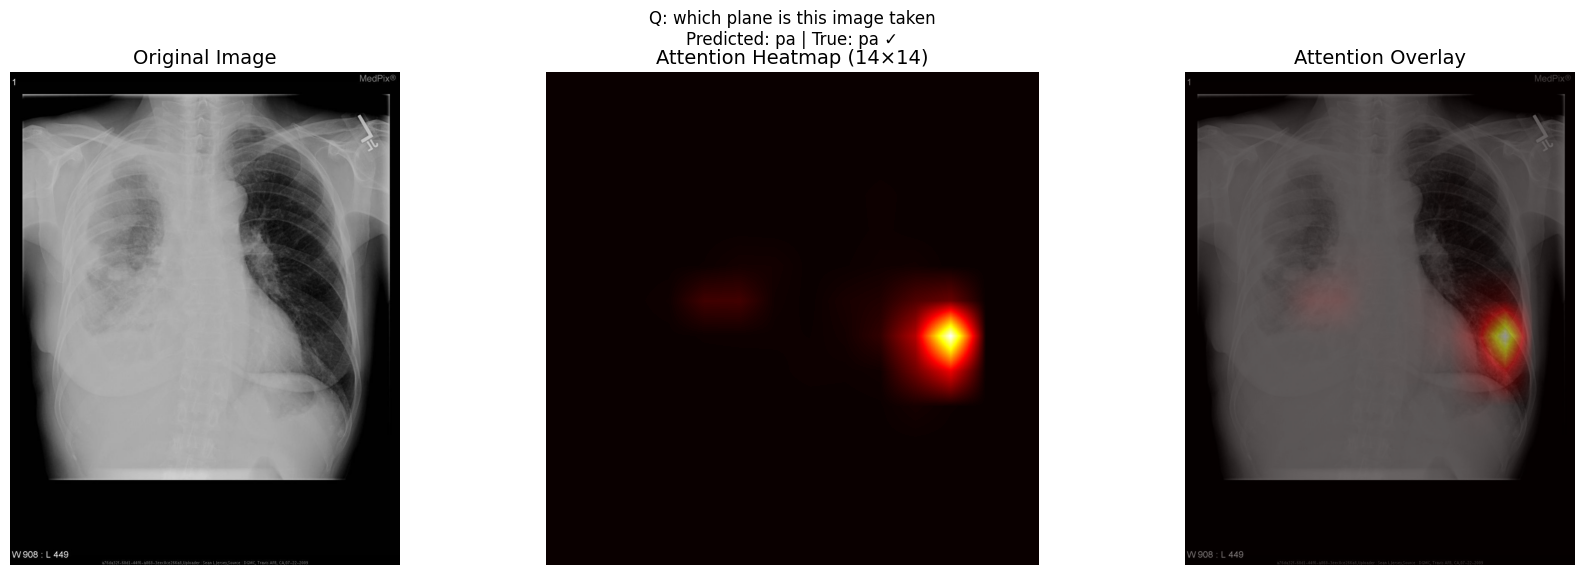

--------------------------------------------------------------------------------
Sample 7:
  Image: synpic35914.jpg
  Question: where is the colon most prominent from this view
  Answer Type: OPEN
  Image Organ: ABD
  Question Type: POS
  True answer: left
  Predicted: abscess
  Correct: False ✗
  Top 5 predictions:
    abscess: 0.2119
    in the bowel: 0.1667
    yes: 0.1596
    enhancement of vessels: 0.1277
    asymmetric: 0.0907


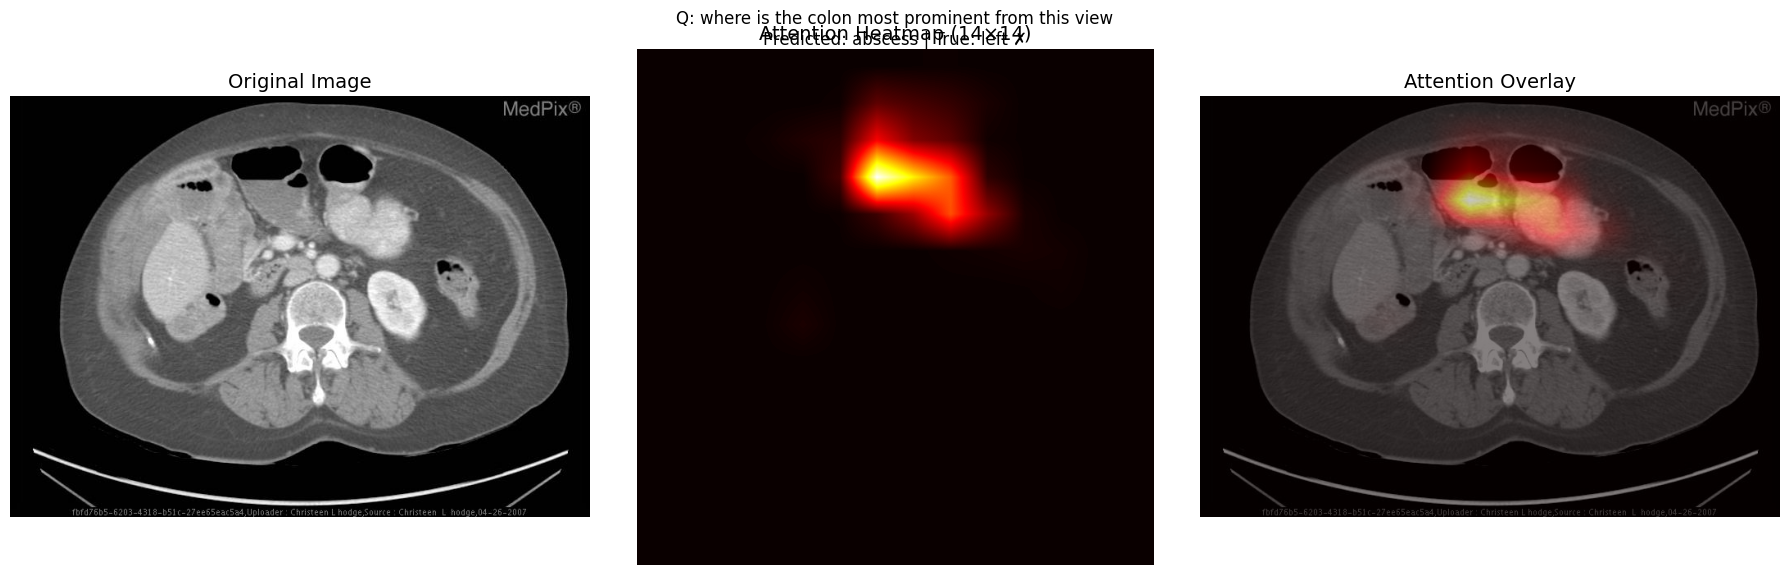

--------------------------------------------------------------------------------
Sample 8:
  Image: synpic53033.jpg
  Question: what side of the brain is a lesion on
  Answer Type: OPEN
  Image Organ: HEAD
  Question Type: POS
  True answer: left
  Predicted: left side
  Correct: False ✗
  Top 5 predictions:
    left side: 0.5808
    no: 0.0670
    right frontal lobe: 0.0577
    left temporal lobe: 0.0266
    right side: 0.0234


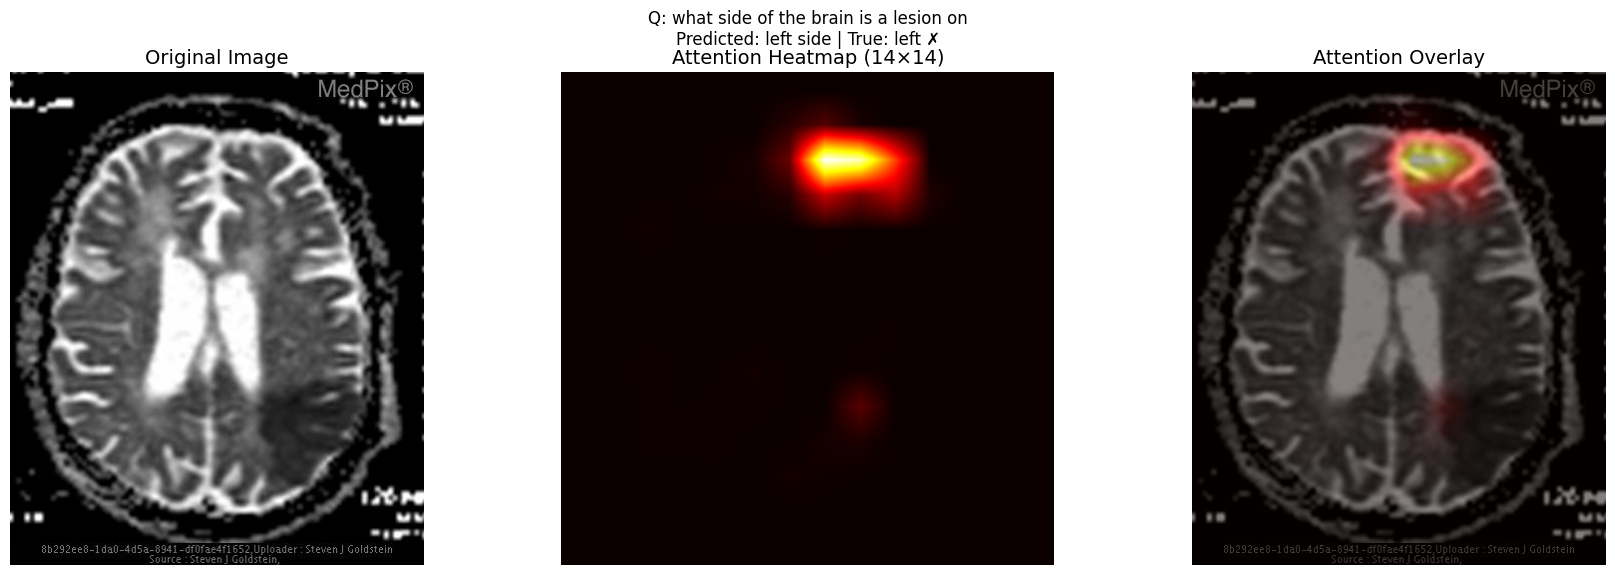

--------------------------------------------------------------------------------
Sample 9:
  Image: synpic52828.jpg
  Question: what imaging modality is used
  Answer Type: OPEN
  Image Organ: ABD
  Question Type: MODALITY
  True answer: ct
  Predicted: ct
  Correct: True ✓
  Top 5 predictions:
    ct: 0.5456
    with contrast: 0.3291
    plain film xray: 0.0198
    blind ending loop of bowel arising from the cecum: 0.0155
    blind loop syndrome: 0.0083


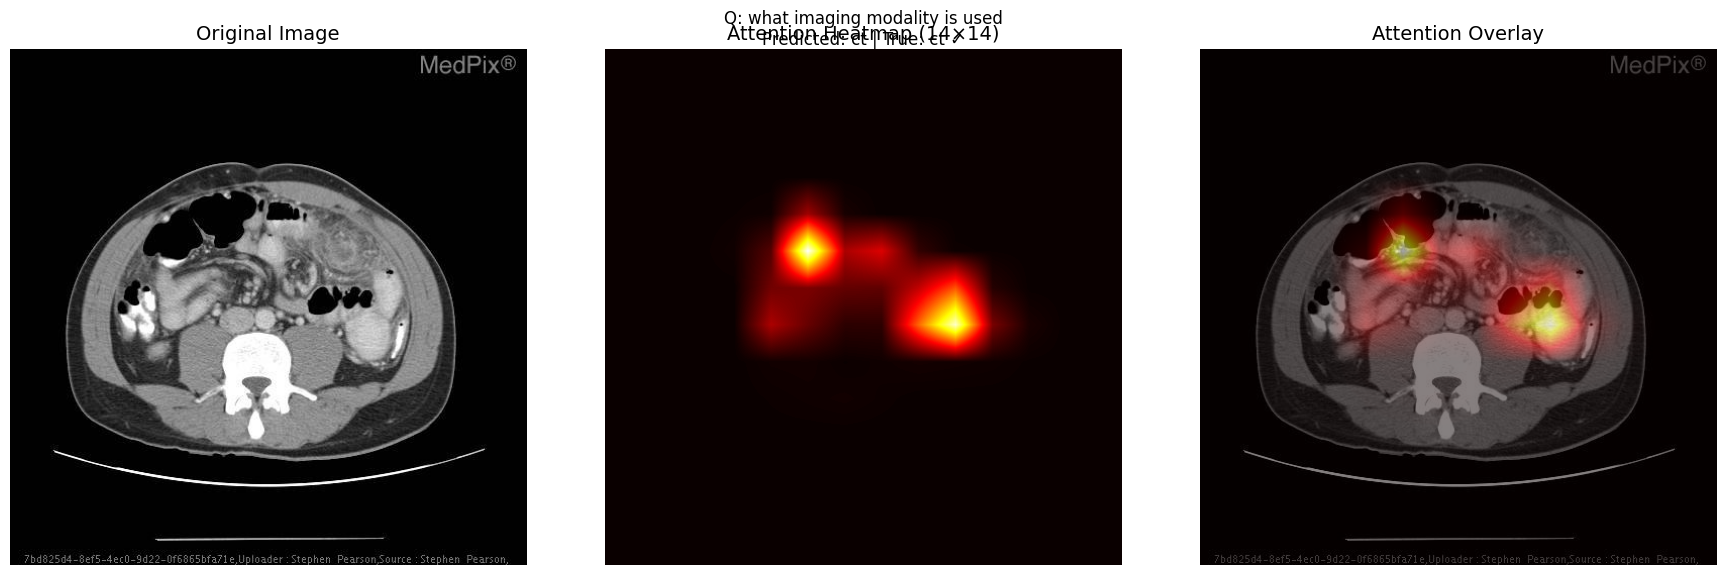

--------------------------------------------------------------------------------
Sample 10:
  Image: synpic27142.jpg
  Question: what organ system is shown
  Answer Type: OPEN
  Image Organ: HEAD
  Question Type: ORGAN
  True answer: brain
  Predicted: brain
  Correct: True ✓
  Top 5 predictions:
    brain: 0.5297
    cortical ribbon of right occipital lobe with extension into right posterior temporal lobe: 0.1426
    cns: 0.1232
    chest: 0.1141
    mr t2 weighted: 0.0345


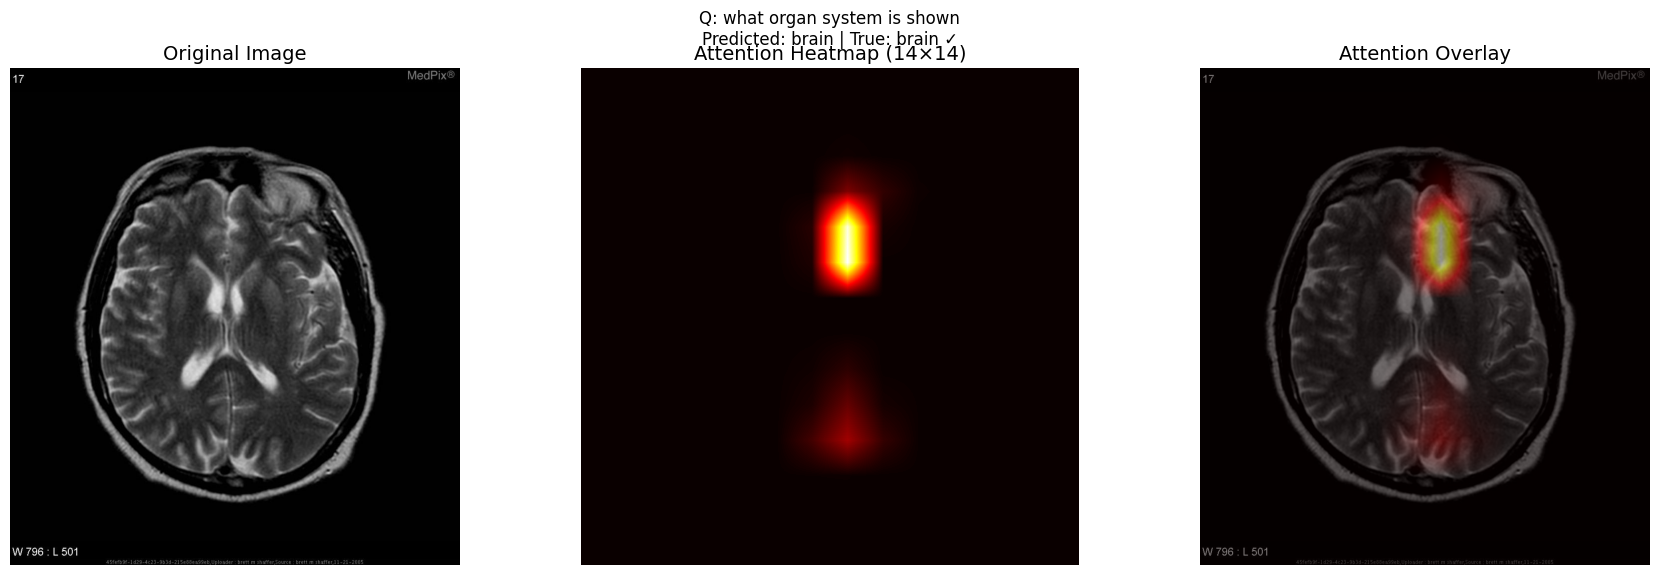

--------------------------------------------------------------------------------



In [ ]:
print("="*80)
print("SAMPLE PREDICTIONS WITH ATTENTION VISUALIZATION")
print("="*80)

# Get answerable indices
answerable_indices = np.where(answerable_mask)[0]

# Separate by answer type
df_test_answerable = df_test.iloc[answerable_indices].reset_index(drop=True)
closed_indices = df_test_answerable[df_test_answerable['answer_type'] == 'CLOSED'].index.tolist()
open_indices = df_test_answerable[df_test_answerable['answer_type'] == 'OPEN'].index.tolist()

# Select 5 from each type
num_closed = min(5, len(closed_indices))
num_open = min(5, len(open_indices))

# Sample evenly across the dataset
closed_samples = []
if num_closed > 0:
    step = len(closed_indices) // num_closed
    closed_samples = [closed_indices[i * step] for i in range(num_closed)]

open_samples = []
if num_open > 0:
    step = len(open_indices) // num_open
    open_samples = [open_indices[i * step] for i in range(num_open)]

# Combine: CLOSED first, then OPEN
sample_indices_local = closed_samples + open_samples
# Convert local indices (in df_test_answerable) to global indices (in df_test)
sample_indices_global = [answerable_indices[idx] for idx in sample_indices_local]

print(f"Showing {len(sample_indices_global)} sample predictions:")
print(f"  CLOSED answer type: {num_closed} samples")
print(f"  OPEN answer type: {num_open} samples")
print()

for i, idx in enumerate(sample_indices_global, 1):
    if idx >= len(df_test):
        continue

    row = df_test.iloc[idx]
    image_path = os.path.join(config.IMAGE_DIR, row['image_name'])

    # Predict
    result = predict_with_attention(
        model, image_path, row['question'],
        word2idx, idx2answer,
        val_test_transform, config.DEVICE
    )

    print(f"Sample {i}:")
    print(f"  Image: {row['image_name']}")
    print(f"  Question: {row['question']}")
    print(f"  Answer Type: {row['answer_type']}")
    print(f"  Image Organ: {row['image_organ']}")
    print(f"  Question Type: {row['question_type']}")
    print(f"  True answer: {row['answer']}")
    print(f"  Predicted: {result['predicted_answer']}")
    correct = result['predicted_answer'] == row['answer']
    print(f"  Correct: {correct} {'✓' if correct else '✗'}")
    print(f"  Top 5 predictions:")
    for ans, prob in result['top5_answers']:
        print(f"    {ans}: {prob:.4f}")

    # Visualize attention
    visualize_attention(
        result['image'],
        result['attention_weights'],
        row['question'],
        result['predicted_answer'],
        row['answer']
    )
    print("-" * 80)

print("\n" + "="*80)